<a href="https://colab.research.google.com/github/d-roland/Fake-news-detection/blob/master/CS221_Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
from collections import Counter, defaultdict
from wordcloud import WordCloud
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, CuDNNLSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime
from statistics import mean
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Gathering data**

## Integrating BuzzFeed Real News

In [4]:
bfreal = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_real_news_content.csv')
bfreal.shape

(91, 12)

In [5]:
bfreal.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin..."
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F..."
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b..."
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict..."


In [6]:
bfreal.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
count,91,91,91,91,91,84,91,56,4,91,90,91
unique,91,91,91,91,87,65,14,53,4,90,90,91
top,Real_86-Webpage,Young Girl's Emotional Council Speech Laments ...,As police today captured the man wanted for qu...,http://cnn.it/2dbrw9X,http://static.politico.com/da/f5/44342c424c68b...,"Jack Shafer,Louis Nelson",http://politi.co,{'$date': 1474329600000},https://www.youtube.com/embed/TxBcCSaBtXc?feat...,http://static.politico.com/da/f5/44342c424c68b...,http://addictinginfo.com/2016/09/27/huffpo-jus...,"{""description"": ""President Barack Obama made a..."
freq,1,1,1,1,3,5,32,2,1,2,1,1


In [7]:
for key,count in bfreal.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bfreal.shape[0]))

http://politi.co:	32
http://cnn.it:	23
http://abcn.ws:	9
http://eaglerising.com:	7
http://rightwingnews.com:	7
http://www.addictinginfo.org:	3
http://addictinginfo.org:	2
http://www.ifyouonlynews.com:	2
http://freedomdaily.com:	1
http://winningdemocrats.com:	1
http://occupydemocrats.com:	1
https://www.washingtonpost.com:	1
http://www.opposingviews.com:	1
http://conservativebyte.com:	1
Total Records:	91


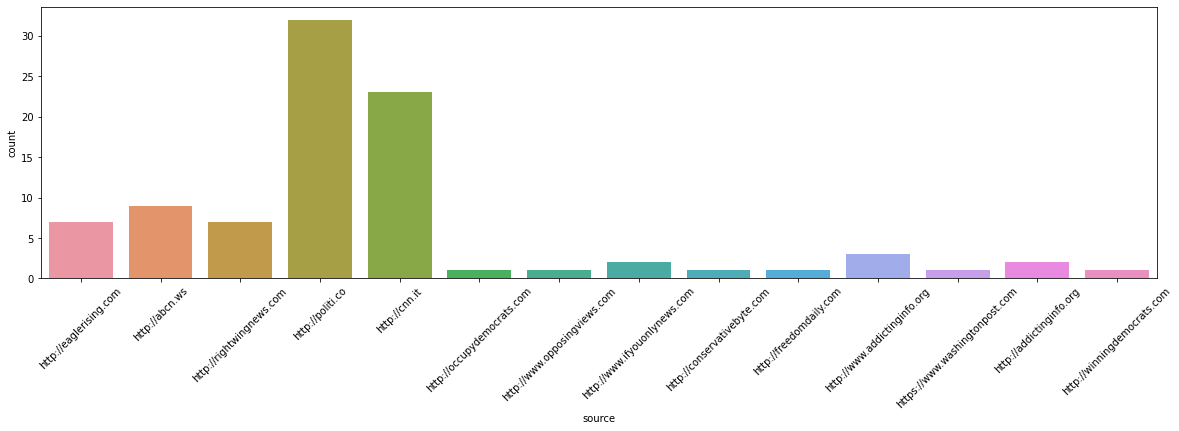

In [8]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bfreal)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [9]:
#checking for rows with empty text
[index for index,text in enumerate(bfreal.text.values) if str(text).strip() == '']

[]

Adding class indication, and an empty subject column, prior to merging with Fake-and-real-news dataset.

In [10]:
bfreal["class"]=1
bfreal["subject"]=''
bfreal.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,subject
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",1,
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",1,
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",1,
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b...",1,
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict...",1,


Removing all polluting expressions in both text and title

In [0]:
#Seperating Publication info, from actual text
pollution_real = ["getty images", "⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_real:
    bfreal['title'] = bfreal['title'].str.replace(i , '')
    bfreal['text'] = bfreal['text'].str.replace(i , '')

## Integrating BuzzFeed Fake News

In [12]:
bffake = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_fake_news_content.csv')
bffake.shape

(91, 12)

In [13]:
bffake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ..."
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis..."
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi..."
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ..."
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty..."


In [14]:
bffake.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
count,91,91,91,83,81,57,83,77,21,81,80,91
unique,91,87,87,80,79,30,22,69,21,79,78,81
top,Fake_57-Webpage,CNN’s Post-Debate Rigged Poll Busted…Here Are ...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,Terresa Monroe-hamilton,http://rightwingnews.com,{'$date': 1474588800000},http://www.youtube.com/embed/XcBbguk05D0?versi...,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36847/clinton-foundatio...,{}
freq,1,2,2,2,2,6,17,4,1,2,2,8


In [15]:
for key,count in bffake.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bffake.shape[0]))

http://rightwingnews.com:	17
http://freedomdaily.com:	16
http://eaglerising.com:	11
http://occupydemocrats.com:	6
https://goo.gl:	3
http://www.addictinginfo.org:	3
http://www.thepoliticalinsider.com:	3
http://conservativetribune.com:	2
http://usherald.com:	2
http://winningdemocrats.com:	2
http://clashdaily.com:	2
http://www.proudcons.com:	2
http://100percentfedup.com:	2
http://theblacksphere.net:	2
https://ihavethetruth.com:	2
http://allenwestrepublic.com:	2
http://conservativebyte.com:	1
http://author.groopspeak.com:	1
http://addictinginfo.org:	1
http://www.chicksontheright.com:	1
http://www.yesimright.com:	1
http://author.addictinginfo.org:	1
Total Records:	91


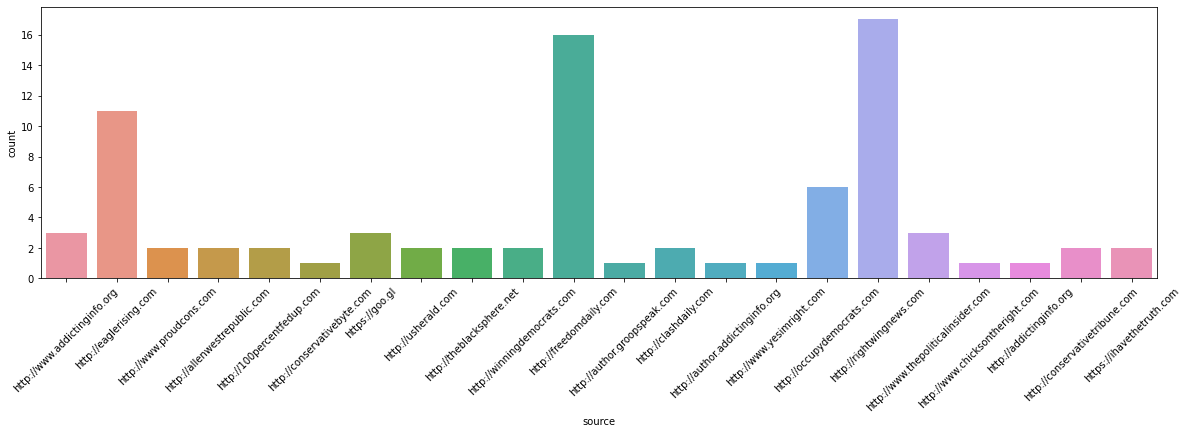

In [16]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bffake)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [17]:
#checking for rows with empty text
[index for index,text in enumerate(bffake.text.values) if str(text).strip() == '']

[]

In [18]:
bffake["class"]=0
bffake["subject"]=''
bffake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,subject
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ...",0,
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis...",0,
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi...",0,
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ...",0,
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty...",0,


Removing all polluting expressions in both text and title

In [0]:
pollution_fake = ["getty images", "⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_fake:
    bffake['title'] = bffake['title'].str.replace(i , '')
    bffake['text'] = bffake['text'].str.replace(i , '')

## Integrating Fake-and-real-news Real News

In [20]:
reald = pd.read_csv('/content/drive/My Drive/CS221_Project/True.csv')
reald.shape

(21417, 4)

In [21]:
reald.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [22]:
for key,count in reald.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(reald.shape[0]))

politicsNews:	11272
worldnews:	10145
Total Records:	21417


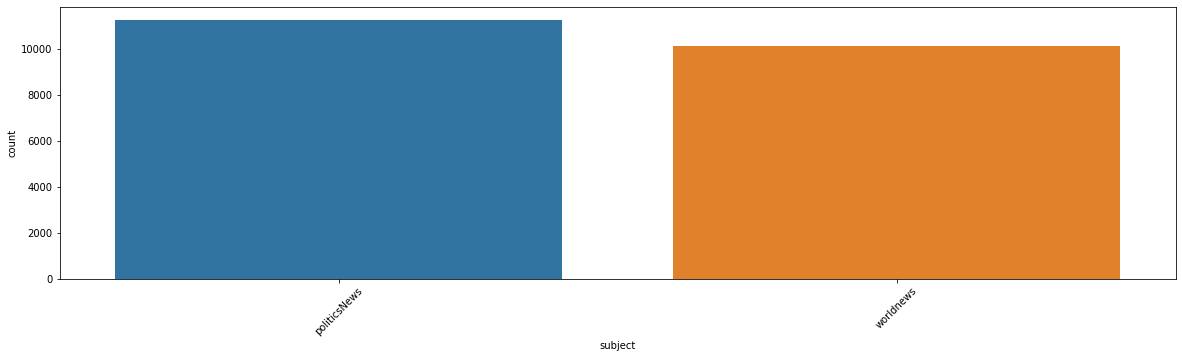

In [23]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=reald)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [24]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(reald.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of publication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)
#Thus we have list of indices where publisher is not mentioned
#lets check
reald.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [25]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for idx,row in enumerate(reald.text.values):
    if idx in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

#Replace existing text column with new text
#add seperate column for publication info in case we want to use it later
reald["source"] = publisher
reald["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers
reald.head()

,title,text,subject,date,source
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [0]:
pollution_reald = ["/Getty Images", "Getty Images", "getty images", "Reuters"]
for i in pollution_reald:
    reald['title'] = reald['title'].str.replace(i , '')
    reald['text'] = reald['text'].str.replace(i , '')

In [27]:
#checking for rows with empty text
[index for index,text in enumerate(reald.text.values) if str(text).strip() == '']

[8970]

In [0]:
#dropping this record
reald = reald.drop(8970, axis=0)

In [29]:
#renaming date column before merging with FakenewsNet dataset, and adding a class column
reald["class"]=1
reald = reald.rename(columns={"date":"publish_date"})
reald.head()

,title,text,subject,publish_date,source,class
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1


## Integrating Fake-and-real-news Fake News

In [30]:
faked = pd.read_csv('/content/drive/My Drive/CS221_Project/Fake.csv')
faked.shape

(23481, 4)

In [31]:
faked.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [32]:
for key,count in faked.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(faked.shape[0]))

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


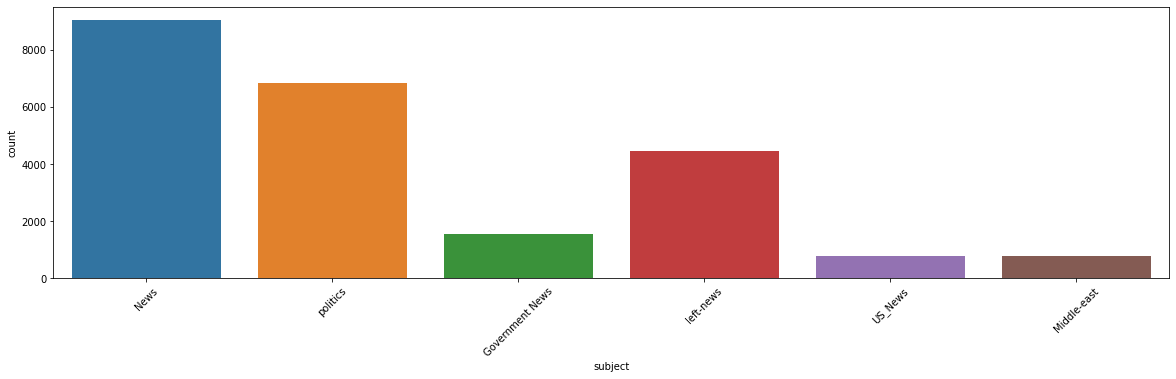

In [33]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=faked)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [34]:
#checking for rows with empty text
empty_faked_index = [index for index,text in enumerate(faked.text.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_faked_index)))
faked.iloc[empty_faked_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [35]:
#dropping this record
for i in empty_faked_index:
  faked = faked.drop(i, axis=0)

faked.shape

(22851, 4)

Removing polluting expressions in both title and text columns

In [0]:
pollution_faked = ["(VIDEO)", "[VIDEO]", "Photo by", "/Getty Images", "Getty Images", "Featured image", "pic.twitter.com"]
for i in pollution_faked:
    faked['title'] = faked['title'].str.replace(i , '')
    faked['text'] = faked['text'].str.replace(i , '')

In [37]:
#renaming date column before merging with FakenewsNet dataset, adding a class column and a source one set to "Unknown"
faked["class"]=0
faked["source"]="Unknown"
faked = faked.rename(columns={"date":"publish_date"})
faked.head()

,title,text,subject,publish_date,class,source
0,onald Trump Sends ut mbarrassing New Year’s v...,onald Trump just couldn t wish all Americans a...,News,"December 31, 2017",0,Unknown
1,runk Bragging Trump Staffer Started Russian C...,House ntelligence Committee Chairman evin Nune...,News,"December 31, 2017",0,Unknown
2,Sheriff avid Clarke Becomes An nternet Joke F...,"n Friday, it was revealed that former Milwauke...",News,"December 30, 2017",0,Unknown
3,Trump s So bsessed He ven Has bama’s Name Cod...,"n Christmas day, onald Trump announced that he...",News,"December 29, 2017",0,Unknown
4,Pope Francis Just Called ut onald Trump uring...,Pope Francis used his annual Christmas ay mess...,News,"December 25, 2017",0,Unknown


## Merging all 4 datasets into one

**Baseline**: merge title and text, and keep only the resulting value along with the class

In [38]:
bfreal_short = bfreal[["title", "text","class"]]
bfreal_short.head()

,title,text,class
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,1


In [39]:
bffake_short = bffake[["title", "text","class"]]
bffake_short.head()

,title,text,class
0,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,0
1,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,0
2,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,0
3,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",0
4,Website is Down For Maintenance,Website is Down For Maintenance,0


In [40]:
reald_short = reald[["title", "text","class"]]
reald_short.head()

,title,text,class
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,1


In [41]:
faked_short = faked[["title", "text","class"]]
faked_short.tail()

,title,text,class
23476,McPain: John McCain Furious That ran Treated U...,21st Century Wire says As 21WR reported earlie...,0
23477,JUSTC? Yahoo Settles -mail Privacy Class-actio...,21st Century Wire says t s a familiar theme. W...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0
23480,10 U.S. Navy Sailors Held by ranian Military –...,21st Century Wire says As 21WR predicted in it...,0


In [42]:
dataset = bfreal_short.append([bffake_short, reald_short, faked_short], ignore_index=True)
dataset.shape

(44449, 3)

In [43]:
#Combining Title and Text
dataset["text"] = dataset["title"] + " " + dataset["text"]
dataset = dataset.drop(["title"], axis=1)
dataset.head()

,text,class
0,Another Terrorist Attack in NYC…Why Are we STI...,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...",1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",1


In [44]:
dataset.tail()

,text,class
44444,McPain: John McCain Furious That ran Treated U...,0
44445,JUSTC? Yahoo Settles -mail Privacy Class-actio...,0
44446,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44447,How to Blow $700 Million: Al Jazeera America F...,0
44448,10 U.S. Navy Sailors Held by ranian Military –...,0


In [45]:
dataset.count()

text     44449
class    44449
dtype: int64

In [46]:
dataset["class"].value_counts()

0    22942
1    21507
Name: class, dtype: int64

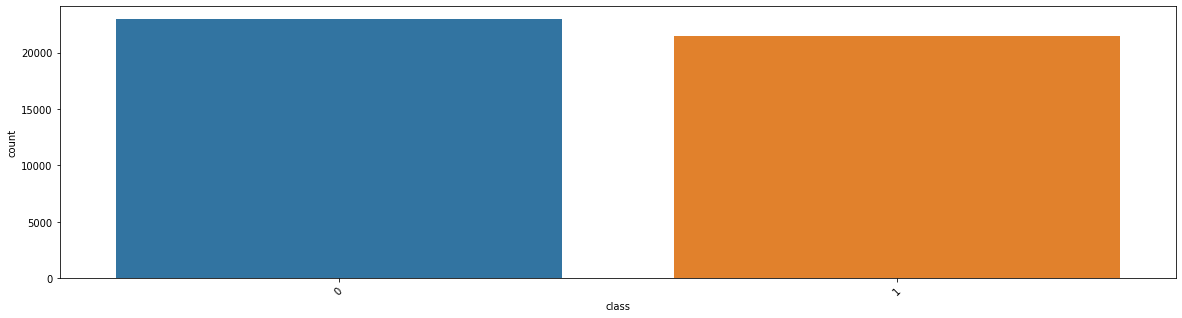

In [47]:
#Plotting total number of Fake and Real news
plt.figure(figsize=(20,5))
chart = sns.countplot("class", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [0]:
del bfreal, bfreal_short, bffake, bffake_short, reald, reald_short, faked, faked_short

# **Generating Oracle**

In [0]:
num_samples = 25
sampled = dataset.sample(n=num_samples)
sampled['text'].to_csv('/content/drive/My Drive/CS221_Project/oracle_data.csv', index=False)

After we've generated the file, we'd fill it out and then
run the following:

In [50]:
num_samples = 50
sampled = pd.read_csv('/content/drive/My Drive/CS221_Project/oracle_data_100_answers.csv')
guesses = pd.read_csv('/content/drive/My Drive/CS221_Project/oracle_data_100_filled.csv')
guesses['roland'] = pd.to_numeric(guesses['roland'])
guesses['sathya'] = pd.to_numeric(guesses['sathya'])
#raw accuracies (preserved just for the record)
accuracy = pd.DataFrame()
accuracy['roland'] = (sampled['class']==guesses['roland'])
accuracy['sathya'] = (sampled['class']==guesses['sathya'])
accuracy_roland = accuracy['roland'].drop(index=list(range(50, 100))).reset_index(drop=True)
accuracy_sathya = accuracy['sathya'].drop(index=list(range(50))).reset_index(drop=True)
accuracy_roland = accuracy['roland'].drop(index=list(range(50, 100))).reset_index(drop=True)
#print(accuracy_roland)
#print(accuracy_sathya)
#accuracy['max'] = (accuracy_sathya | accuracy_roland) #picking the right answer if one of us chose it
#accuracy['min'] = (accuracy_sathya & accuracy_roland) #picking the wrong answer if one of us chose it
print("Roland accuracy: ", sum(accuracy_roland)/num_samples)
print("Sathya accuracy: ", sum(accuracy_sathya)/num_samples)
print("Combined accuracy: ", (sum(accuracy_sathya) + sum(accuracy_roland))/(2*num_samples))

#classification reports
guesses_roland = guesses['roland'].drop(index=list(range(49, 100))).reset_index(drop=True)
answers_roland = sampled['class'].drop(index=list(range(49, 100))).reset_index(drop=True)
#print(answers['roland'])
guesses_sathya = guesses['sathya'].drop(index=list(range(50))).reset_index(drop=True)
answers_sathya = sampled['class'].drop(index=list(range(50))).reset_index(drop=True)

print("Roland's Classification Report")
print(classification_report(guesses_roland, answers_roland))

print("Sathya's Classification Report")
print(classification_report(guesses_sathya, answers_sathya))

print("Combined Classification Report")
print(classification_report(guesses_roland.append(guesses_sathya), answers_roland.append(answers_sathya)))

Roland accuracy:  0.76
Sathya accuracy:  0.94
Combined accuracy:  0.85
Roland's Classification Report
              precision    recall  f1-score   support

         0.0       0.83      0.65      0.73        23
         1.0       0.74      0.88      0.81        26

    accuracy                           0.78        49
   macro avg       0.79      0.77      0.77        49
weighted avg       0.78      0.78      0.77        49

Sathya's Classification Report
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        27
         1.0       1.00      0.87      0.93        23

    accuracy                           0.94        50
   macro avg       0.95      0.93      0.94        50
weighted avg       0.95      0.94      0.94        50

Combined Classification Report
              precision    recall  f1-score   support

         0.0       0.88      0.84      0.86        50
         1.0       0.84      0.88      0.86        49

    accuracy      

# **Data Preprocessing**

## Data cleaning

In [0]:
"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove emojis from the text.

"""

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
dataset['text'] = dataset["text"].apply(lambda x: remove_nums(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_URL(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_html(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_emoji(x))

In [0]:
%%capture
#!pip install spellchecker
#!pip install indexer
#!pip install pyspellchecker

In [0]:
# OPTIONAL - VERY SLOW - Spelling correction

#from spellchecker import SpellChecker

#spell = SpellChecker()
#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = spell.unknown(text.split())
#    for word in text.split():
#        if word in misspelled_words:
#            corrected_text.append(spell.correction(word))
#        else:
#            corrected_text.append(word)
#    return " ".join(corrected_text)

#dataset["text"].apply(lambda text: correct_spellings(text))
#dataset.head(10)

## Tokenization and stopwords removal

In [0]:
y = []
y = dataset["class"].values
#Converting X to format acceptable by gensim, removing stopwords and punctuation in the process
stop_words = set(nltk.corpus.stopwords.words("english"))
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in dataset["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

#del dataset

In [57]:
X[1][:10]

['donald',
 'trump',
 'drugs',
 'big',
 'factor',
 'charlotte',
 'protests',
 'less',
 'day',
 'protests']

In [58]:
#Confirming that X is a list of all news and y contains all classes
print(len(X), len(y))

44449 44449


In [59]:
#checking for rows with empty text
empty_X_lines = [index for index,text in enumerate(X) if text == []]
print(empty_X_lines)

[30956, 36727, 36728, 37030, 37031, 38550, 38551, 42838, 42839]


In [60]:
#Dropping those lines in both X and y
for i in reversed(empty_X_lines):
  del X[i]
  y = np.delete(y,i)

print(len(X), len(y))

44440 44440


## Dataset size fine tuning

In [61]:
#Optional - Removing news of less than 100 words
LOWER_BOUND = 100

lower_lines = []
lower_lines = [index for index,text in enumerate(X) if len(text)<LOWER_BOUND]

print(len(lower_lines)/len(X))

0.19252925292529252


In [62]:
#Dropping those lines in both X and y
for i in reversed(lower_lines):
  del X[i]
  y = np.delete(y,i)

print(len(X), len(y))

35884 35884


In [63]:
#Optional - Removing news of more than 700 words

UPPER_BOUND = 450

upper_lines = []
upper_lines = [index for index, text in enumerate(X) if len(text)>UPPER_BOUND]
print(len(upper_lines)/len(X))

0.1136160963103333


In [64]:
#Dropping those lines in both X and y
for i in reversed(upper_lines):
  del X[i]
  y = np.delete(y,i)

print(len(X), len(y))

31807 31807


In [65]:
#Identifying indexes of real and fake news
real_idx = [i for i,v in enumerate(y) if v == 1]
fake_idx = [i for i,v in enumerate(y) if v == 0]
print(len(real_idx), len(fake_idx))

13632 18175


In [0]:
#Making these two set of indexes of equal length
min_size = min(len(real_idx), len(fake_idx))
real_idx = random.sample(real_idx, min_size)
fake_idx = random.sample(fake_idx, min_size)

In [67]:
X_real = []
X_fake = []
X_real = [X[i] for i in real_idx]
X_fake = [X[j] for j in fake_idx]
print(len(X_real), len(X_fake))

13632 13632


In [68]:
X = []
y = []
X = X_real + X_fake
y = [1] * len(X_real) + [0] * len(X_fake)
print(len(X), len(y))

27264 27264


## Optional - Frequent words removal

In [0]:
# OPTIONAL - Removing frequent and rare words from X_real

cnt_real = Counter()
for news in X_real:
  for word in news:
    cnt_real[word] += 1

n_rare_words = 10
RAREWORDS_real = set([w for (w, wc) in cnt_real.most_common()[:-n_rare_words-1:-1]])
        
FREQWORDS_real = set([w for (w, wc) in cnt_real.most_common(15)])

print('Rare words in Real dataset:', RAREWORDS_real)
print('Frequent words in Real dataset:', FREQWORDS_real)

In [0]:
X_real_freq = []
tmp = []
for news in X_real:
  filtered_words = [w.strip() for w in news if w not in FREQWORDS_real and w not in RAREWORDS_real]
  tmp.append(filtered_words)
X_real_freq.extend(tmp)

X_real_freq[1][:10]

In [0]:
# OPTIONAL - Removing frequent and rare words from X_fake

cnt_fake = Counter()
for news in X_fake:
  for word in news:
    cnt_fake[word] += 1

n_rare_words = 10
RAREWORDS_fake = set([w for (w, wc) in cnt_fake.most_common()[:-n_rare_words-1:-1]])
        
FREQWORDS_fake = set([w for (w, wc) in cnt_fake.most_common(15)])

print('Rare words in Fake dataset:', RAREWORDS_fake)
print('Frequent words in Fake dataset:', FREQWORDS_fake)

In [0]:
X_fake_freq = []
tmp = []
for news in X_fake:
  filtered_words = [w.strip() for w in news if w not in FREQWORDS_fake and w not in RAREWORDS_fake]
  tmp.append(filtered_words)
X_fake_freq.extend(tmp)

X_fake_freq[1][:10]

In [0]:
#Recreating X with removed frequencies
X_freq = X_real_freq + X_fake_freq
y_freq = [1] * len(X_real_freq) + [0] * len(X_fake_freq)
print(len(X_freq), len(y_freq))

#Uncomment the following if you want to replace the original "X" to impact all following steps with removed frequencies
X = []
y = []
X = X_freq
y = y_freq
X_real = []
X_fake = []
X_real = X_real_freq
X_fake = X_fake_freq

## Optional - Keeping only words from common dictionary

In [69]:
#Optional - Keeping only words from common dictionary
real_words = defaultdict(int)
fake_words = defaultdict(int)
common_words = []

print("Before dictionary adjustment, Size of X_real: ", len(X_real), "Size of X_fake: ", len(X_fake))
for news in X_real:
  for word in news:
    real_words[word] += 1

for news in X_fake:
  for word in news:
    fake_words[word] += 1

list_real_words = list(real_words.keys())
list_fake_words = list(fake_words.keys())

print("Dictionary size for X_real: ", len(list_real_words), "Dictionary size for X_fake: ", len(list_fake_words))

common_words = [word for word in list_real_words if word in list_fake_words]

print("Total unique words common to both dictionaries: ",len(common_words))

Before dictionary adjustment, Size of X_real:  13632 Size of X_fake:  13632
Dictionary size for X_real:  55846 Dictionary size for X_fake:  72165
Total unique words common to both dictionaries:  31128


In [70]:
#Analizing common words with very high frequency in one corpus vs the other
vocab_frequency = defaultdict(int)
for word in common_words:
  vocab_frequency[word] = round(np.abs(real_words[word]-fake_words[word])/max(len(real_words), len(fake_words)),2)

vocab_frequency = {k: v for k, v in sorted(vocab_frequency.items(), key=lambda item: item[1], reverse = True)}

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

most_frequent = take(50, vocab_frequency.items())
print(most_frequent)

[('said', 0.64), ('trump', 0.3), ('government', 0.13), ('state', 0.11), ('would', 0.11), ('like', 0.11), ('obama', 0.09), ('donald', 0.09), ('hillary', 0.09), ('via', 0.09), ('people', 0.08), ('democratic', 0.08), ('minister', 0.08), ('united', 0.08), ('states', 0.08), ('china', 0.08), ('north', 0.07), ('year', 0.07), ('even', 0.07), ('us', 0.07), ('know', 0.07), ('security', 0.06), ('court', 0.06), ('two', 0.06), ('election', 0.06), ('black', 0.06), ('house', 0.06), ('tuesday', 0.06), ('percent', 0.06), ('america', 0.06), ('told', 0.06), ('last', 0.06), ('republican', 0.06), ('get', 0.06), ('senate', 0.06), ('party', 0.06), ('clinton', 0.06), ('department', 0.06), ('wednesday', 0.06), ('video', 0.06), ('iran', 0.06), ('watch', 0.06), ('monday', 0.05), ('news', 0.05), ('thursday', 0.05), ('could', 0.05), ('officials', 0.05), ('right', 0.05), ('week', 0.05), ('new', 0.05)]


In [71]:
#Optional - removing words frequent only in one corpus from common dictionary
most_frequent_words = []
most_frequent_words = [w for w in vocab_frequency.keys()]

for word in most_frequent_words:
  if float(round(np.abs(real_words[word]-fake_words[word])/max(len(real_words), len(fake_words)),2)) > 0.01:
    common_words.remove(word)

print(len(common_words))

30804


In [72]:
X_real = [[word for word in news if word in common_words] for news in X_real]
X_fake = [[word for word in news if word in common_words] for news in X_fake]

"""
for news in X_real:
    for word in common_words:
        if word in news:
            news = [item.replace(word, "") for item in news]

for news in X_fake:
    for word in common_words:
        if word in news:
            news = [item.replace(word, "") for item in news]
"""
print("After dictionary adjustment, Size of X_real: ", len(X_real), "Size of X_fake: ", len(X_fake))

After dictionary adjustment, Size of X_real:  13632 Size of X_fake:  13632


In [73]:
#Check number of possible empty lines in both corpus after dictionary cleaning
empty_X_lines_real = [index for index,text in enumerate(X_real) if text == []]
empty_X_lines_fake = [index for index,text in enumerate(X_fake) if text == []]
print("Real: ", empty_X_lines_real, "Fake :", empty_X_lines_fake)

Real:  [] Fake : []


In [0]:
X = []
y = []
X = X_real + X_fake
y = [1] * len(X_real) + [0] * len(X_fake)

In [75]:
print(len(X), len(y))

27264 27264


In [0]:
#put X back together and save as a CSV for input into BERT.
bert_dataset = []
for entry in X:
  bert_dataset.append(' '.join(entry))
bert_dataset = np.asarray(bert_dataset) 
bert_dataset = pd.DataFrame(data=bert_dataset, columns=["text"])
bert_dataset['class'] = y

In [77]:
bert_dataset.to_csv('/content/drive/My Drive/CS221_Project/bert_dataset.csv', index=False)
bert_dataset.head(10)

,text,class
0,seven arrested raising rainbow flag concert po...,1
1,baltimore primary results irregularities cited...,1
2,seeks climate measures progress trudeau barack...,1
3,bolivia morales leads che homage years executi...,1
4,senators seek slash legal immigration senators...,1
5,vows fair nomination process uproar head satur...,1
6,votes smooth cigarette regulatory path approve...,1
7,ex adviser flynn talking testifying probe lawy...,1
8,investigate rocky poster coup links turkish la...,1
9,lesbian wins spousal visa landmark hong kong c...,1


## Optional - Lemmatization

In [0]:
# OPTIONAL - Lemmatization while respecting the POS

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(lemmatizer.lemmatize(word))
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

bert_dataset["text"] = bert_dataset["text"].apply(lambda text: lemmatize_sentence(text))
bert_dataset.head(10)

In [0]:
bert_dataset.to_csv('/content/drive/My Drive/CS221_Project/bert_dataset.csv', index=False)

In [0]:
#Putting lemmatized content back into X as well 
tmp = []
X = []
y = []

y = bert_dataset["class"].values

token = nltk.tokenize.RegexpTokenizer(r'\w+')
for line in bert_dataset["text"].values:
    sentences = nltk.sent_tokenize(line)
    for sentence in sentences:
        tokens = token.tokenize(sentence)
        filtered_w = [w.strip() for w in tokens]
        tmp.extend(filtered_w)
    X.append(tmp)


In [0]:
real_idx_2 = [i for i,v in enumerate(y) if v == 1]
fake_idx_2 = [i for i,v in enumerate(y) if v == 0]
min_size_2 = min(len(real_idx_2), len(fake_idx_2))
real_idx_2 = random.sample(real_idx_2, min_size_2)
fake_idx_2 = random.sample(fake_idx_2, min_size_2)

X_real = []
X_fake = []
X_real = [X[i] for i in real_idx_2]
X_fake = [X[j] for j in fake_idx_2]
print(len(X_real), len(X_fake))

In [0]:
X_real[1][:10]

# **Vectorization**

## Via TF-IDF

In [78]:
#Manually generating Train/Test sets
test_set_size = 0.15*float(len(bert_dataset))
test_idx = random.sample(range(len(bert_dataset)),int(test_set_size))

X_test = []
y_test = []
for idx in test_idx:
  X_test.append(bert_dataset["text"].iloc[idx])
  y_test.append(bert_dataset["class"].iloc[idx])

X_test = np.array(X_test)
y_test = np.array(y_test)

train_idx = [j for j in range(len(bert_dataset))]
for i in test_idx:
  train_idx.remove(i)
  
X_train = []
y_train = []
for idx in train_idx:
  X_train.append(bert_dataset["text"].iloc[idx])
  y_train.append(bert_dataset["class"].iloc[idx])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(len(X_train), len(X_test))
del test_idx, train_idx

23175 4089


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [80]:
X_train_tfidf.shape

(23175, 30752)

In [81]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [82]:
vader_X_train = []
vader_X_test = []

for i in range(len(X_train)):
  vader_X_train.append(vader.polarity_scores(str(X_train[i])))

comp_X_train = []
for j in range(len(vader_X_train)):
  comp_X_train.append(vader_X_train[j]['compound'])

comp_X_test = []
for j in range(len(vader_X_test)):
  comp_X_test.append(vader_X_test[j]['compound'])



NameError: ignored

## Via Word2Vec

In [0]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=5)

In [84]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each word by a 100dim vector.

26379

In [0]:
#see a sample vector for random word 
#w2v_model["clinton"]

In [0]:
#w2v_model.wv.most_similar("foundation")

In [87]:
# visualize embeddings  ==> Takes too long given dictionary size. Will rather try Kmeans on vectors in Data Analysis
"""
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
"""

"\nfrom sklearn.manifold import TSNE\n\nwords = w2v_model.wv.index2word\nwvs = w2v_model.wv[words]\n\ntsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)\nnp.set_printoptions(suppress=True)\nT = tsne.fit_transform(wvs)\nlabels = words\n\nplt.figure(figsize=(12, 6))\nplt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')\nfor label, x, y in zip(labels, T[:, 0], T[:, 1]):\n    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')\n"

## Tokenization with Keras

In [0]:
# Tokenizing Text -> Representing each word by a number
# Mapping of original word to number is preserved in word_index property of tokenizer

#Tokenizer applies basic processing like changing it to lower case, explicitely setting that as True even if already done before

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

X_tok = tokenizer.texts_to_sequences(X)

In [89]:
# lets check the first 10 words of first news
#every word has been represented with a number
X_tok[0][:10]

[428, 301, 1238, 7277, 493, 3713, 9, 301, 428, 89]

In [90]:
#Lets check few word to numerical representation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

campaign -> 1
first -> 2
country -> 3
years -> 4
may -> 5
say -> 6
republicans -> 7
made -> 8
police -> 9
according -> 10


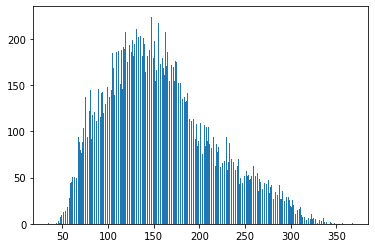

In [91]:
# Making histogram for no of words in news shows that most news article are under 700 words.
plt.hist([len(x) for x in X_tok], bins=500)
plt.show()

In [92]:
# Most of the news have less than 700 words
nos = np.array([len(x) for x in X_tok])
print(len(nos[nos  < UPPER_BOUND])/len(X_tok))

1.0


In [93]:
print(len(nos[nos  > UPPER_BOUND])/len(X_tok))

0.0


In [0]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 200 

#Making all news of size maxlen defined above, padding with 0 when needed
X_tok = pad_sequences(X_tok, maxlen=maxlen)

In [95]:
#Checking
len(X_tok[0])

200

In [0]:
#Saving this tokenized and vectorized version to file
#with open('/content/drive/My Drive/CS221_Project/X_tok.csv', 'w') as myfile:
#    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#    wr.writerow(X_tok)

In [0]:
X_train_tok, X_test_tok, y_train_tok, y_test_tok = train_test_split(X_tok, y, test_size = 0.15) 

# **Modelization** 

## Naïve Bayes model

In [0]:
from sklearn.naive_bayes import MultinomialNB

On basic Keras tokenized input

In [0]:
naive_bayes_model_tok = MultinomialNB().fit(X_train_tok,y_train_tok)

In [100]:
predictions_nb_tok = naive_bayes_model_tok.predict(X_test_tok)
print(classification_report(y_test_tok, predictions_nb_tok))

              precision    recall  f1-score   support

           0       0.52      0.63      0.57      2010
           1       0.55      0.45      0.49      2080

    accuracy                           0.54      4090
   macro avg       0.54      0.54      0.53      4090
weighted avg       0.54      0.54      0.53      4090



On TF-IDF vectorized input

In [0]:
naive_bayes_model = MultinomialNB().fit(X_train_tfidf,y_train)

In [102]:
train_acc = metrics.accuracy_score(y_train, naive_bayes_model.predict(X_train_tfidf))
print("Training accuracy: ", train_acc)

Training accuracy:  0.9318230852211434


In [103]:
#Model Evaluation
predictions = naive_bayes_model.predict(X_test_tfidf)
print(predictions)

[0 1 1 ... 1 0 1]


In [104]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2018
           1       0.92      0.92      0.92      2071

    accuracy                           0.92      4089
   macro avg       0.92      0.92      0.92      4089
weighted avg       0.92      0.92      0.92      4089



## Support Vector Machine

In [0]:
from sklearn.svm import SVC

On basic Keras tokenized input

In [0]:
# Doesn't seem to work well. Likely due to lack of efficient features for the SVC model

#linear_svm_classifier_tok = SVC(kernel = "linear").fit(X_train_tok, y_train_tok)

In [0]:
#predictions_svm_tok = linear_svm_classifier_tok.predict(X_test_tok)
#print(classification_report(y_test_tok, predictions_svm_tok))

On TF-IDF vectorized input

In [0]:
linear_svm_classifier_tfidf = SVC(kernel = "linear").fit(X_train_tfidf,y_train)

In [184]:
train_acc_svm = metrics.accuracy_score(y_train, linear_svm_classifier_tfidf.predict(X_train_tfidf))
print("Training accuracy: ", train_acc_svm)

Training accuracy:  0.9945199568500539


In [185]:
predictions_svm_tfidf = linear_svm_classifier_tfidf.predict(X_test_tfidf)
print(predictions_svm_tfidf)

[0 1 0 ... 1 0 1]


In [186]:
print(classification_report(y_test, predictions_svm_tfidf))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2018
           1       0.98      0.97      0.98      2071

    accuracy                           0.98      4089
   macro avg       0.98      0.98      0.98      4089
weighted avg       0.98      0.98      0.98      4089



## Simple Neural Network

In [0]:
# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [0]:
# Function to create weight matrix between word-index and vectors from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try: 
          weight_matrix[i] = model[word]
        except:
          pass
    return weight_matrix

In [0]:
#Getting embedding vectors from word2vec and using it as weights of non-trainable keras embedding layer
#This embedding layer accepts numerical-token of word and outputs corresponding vector to inner layer.
#It sends vector of zeros to next layer for unknown words which would be tokenized to 0.
#Input length of embedding Layer is the length of each news (700 now due to padding and truncating)
%%capture
#del embedding_vectors
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [190]:
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [191]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

dnn_history = dnn_model.fit(X_train_tok, y_train_tok, epochs=10, validation_split = 0.2, \
                        callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 18539 samples, validate on 4635 samples
Epoch 1/10
18539/18539 [==============================] - 2s 96us/sample - loss: 0.3579 - acc: 0.8547 - val_loss: 0.2916 - val_acc: 0.8846
Epoch 2/10
18539/18539 [==============================] - 2s 91us/sample - loss: 0.2919 - acc: 0.8816 - val_loss: 0.2746 - val_acc: 0.8906
Epoch 3/10
18539/18539 [==============================] - 2s 93us/sample - loss: 0.2790 - acc: 0.8871 - val_loss: 0.2624 - val_acc: 0.8977
Epoch 4/10
18539/18539 [==============================] - 2s 91us/sample - loss: 0.2706 - acc: 0.8920 - val_loss: 0.2540 - val_acc: 0.8999
Epoch 5/10
18539/18539 [==============================] - 2s 88us/sample - loss: 0.2643 - acc: 0.8935 - val_loss: 0.2550 - val_acc: 0.8956


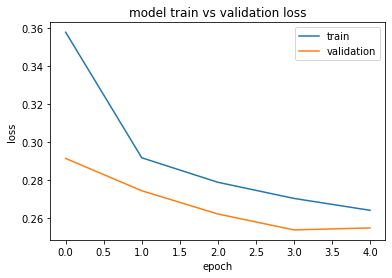

In [192]:
plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [193]:
dnn_results = dnn_model.evaluate(X_test_tok, y_test_tok, batch_size=128)

print('Regular dense network - test loss: {}'.format(dnn_results[0]))
print('Regular dense network - test accuracy: {}'.format(dnn_results[1]))

4090/4090 [==============================] - 0s 16us/sample - loss: 0.2845 - acc: 0.8897
Regular dense network - test loss: 0.2845360693838311
Regular dense network - test accuracy: 0.8897310495376587


In [194]:
dnn_pred = (dnn_model.predict(X_test_tok) >= 0.5).astype("int")

print("Model type: Regular dense neural network.")
print(classification_report(y_test_tok, dnn_pred))

Model type: Regular dense neural network.
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2010
           1       0.87      0.93      0.90      2080

    accuracy                           0.89      4090
   macro avg       0.89      0.89      0.89      4090
weighted avg       0.89      0.89      0.89      4090



In [195]:
print(confusion_matrix(y_test_tok, dnn_pred))

[[1714  296]
 [ 155 1925]]


## Many to one LSTM

In [0]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

#del embedding_vectors

In [197]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          3080500   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,210,749
Trainable params: 130,249
Non-trainable params: 3,080,500
_________________________________________________________________


In [0]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, y_train_tok, validation_split=0.2, epochs=6, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 18539 samples, validate on 4635 samples
Epoch 1/6
18539/18539 [==============================] - 195s 11ms/sample - loss: 0.3154 - acc: 0.8633 - val_loss: 0.2136 - val_acc: 0.9126
Epoch 2/6
 2400/18539 [==>...........................] - ETA: 2:42 - loss: 0.2404 - acc: 0.9017

In [0]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
#Prediction is in probability of news being real, so converting into classes
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [0]:
print(classification_report(y_test_tok, lstm_pred))

In [0]:
print(confusion_matrix(y_test_tok, lstm_pred))

## BERT 

Leveraging work from [this colab](https://colab.sandbox.google.com/drive/1W8yYgQJ6AAvwZ3AdfuPDLirqXOtHbmuO#scrollTo=6o2a5ZIvRcJq)

In [105]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 6.5MB/s 


In [0]:
%load_ext tensorboard

In [107]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [108]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'model_out'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: model_out *****


In [0]:
#Import dataset file if not done already
dataset_processed = pd.read_csv('/content/drive/My Drive/CS221_Project/bert_dataset.csv')

In [110]:
train_df = dataset_processed.sample(frac=0.7, replace=False, random_state=1)
val_df = dataset_processed.sample(frac=0.15, replace=False, random_state=1)
test_df = dataset_processed.sample(frac=0.15, replace=False, random_state=1)
print(train_df.shape, val_df.shape, test_df.shape)

(19085, 2) (4090, 2) (4090, 2)


In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

dev_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

test_InputExamples = test_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

In [112]:
# In order to preprocess the data, we'll load a vocabulary file and lowercasing information directly from the BERT tf hub module
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer_bert = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [113]:
tokenizer_bert.tokenize("betsy devos gets skewered after dept. of education posts embarrassingly misspelled tweets donald trump s education department is pathetic now that betsy devos is in control, and this proves it.devos first week as secretary of education has been terrible to say the least.first, she was blocked from entering a public school by protesters and ran away. then she posted a tweet jokingly asking where the pencils are, which drew a sharp rebuke from teachers, who did not find her joke funny because they usually have to buy their own school supplies for their classrooms.and so, the department of education under devos rule is off to a rough start, and it got downright embarrassing on sunday as americans watched in horror as the education department proceeded to post twitter messages containing misspelled words.seriously. this is the f*cking department of education we are talking about. spelling should be in their wheelhouse. but because of trump and devos, that skill has apparently been lost.in celebration of black history month, the department of education decided to recognize and quote w.e.b. du bois. it did not go well.education must not simply teach work it must teach life. w.e.b. debois /re4cwkpsfa us dept of education (@usedgov) february 12, 2017that s right. devos and her team actually misspelled du bois name. and mockery and outrage rained down upon them for it.welp, this is a foreshadowing of what #betsydevos is going to usher in @usedgov. ffs! it s #blackhistorymonth too!??w. e. b. du bois?? /qkhyauyp6i khary penebaker (@kharyp) february 12, 2017@usedgov looks like @betsydevos is in charge now! /paajszsusl mike flacy (@mikeflacy) february 12, 2017.@usedgov *w.e.b. du boisall good. not like this is the official twitter for the us department of education. ? ryan wyatt (@fwiz) february 12, 2017@usedgov i am glad my public school teachers taught me how to properly spell the names of noted scholars!! maris kreizman (@mariskreizman) february 12, 2017@usedgov omg, it s dubois. who is in charge over there? oh, wait, i get it. jennifer morgan (@profjlmorgan) february 12, 2017.@usedgov first y all thought frederick douglass was alive, now you can t spell du bois. this bodes well for an already faltering system. mehreen kasana (@mehreenkasana) february 12, 2017hilarious, @usedgov. it s either a terrible mistake or a perverse foray into humor. his name is w.e.b. du bois. screenshot saved. /dfdv887rne jeffrey guterman (@jeffreyguterman) february 12, 2017@jeffreyguterman @usedgov is @betsydevos in charge of social media content too? was she distracted by a grizzly? ? @pc7 (@pjcc777) february 12, 2017@usedgov how the hell do you misspell his name? if this isn t foreshadowing the shitstorm of #betsydevos, then i don t know what is s vion (@savionwright) february 12, 2017i see they left ms. duvos in charge of the @usedgov twitter feed /sw0scgm49u jason tocci (@jasont) february 12, 2017protesters should ve let @betsydevos into the school long enough to learn how to spell his name correctly @usedgovhttps://t.co/pdzsgu5xev carlton banksy (@rtyson82) february 12, 2017and if that wasn t enough, the department of education posted a corrected version and then posted an apology tweet that was also misspelled.again, seriously. education must not simply teach work it must teach life. w.e.b. du bois /hsg4r1rlhh us dept of education (@usedgov) february 12, 2017 our deepest apologizes /0staogo3fd josh billinson (@jbillinson) february 12, 2017even reading rainbow star levar burton chimed in.heaven help us! the dept. of education misspelled dubois #bydhttmwfi https://t.co/pt6i1em8an levar burton (@levarburton) february 12, 2017betsy devos hasn t even been in charge for a full week and she has already repeatedly proved that while money can buy a cabinet seat, in her case it could not buy a decent education. via chip somodevilla")

['betsy',
 'dev',
 '##os',
 'gets',
 'sk',
 '##ew',
 '##ered',
 'after',
 'dept',
 '.',
 'of',
 'education',
 'posts',
 'embarrassing',
 '##ly',
 'miss',
 '##pel',
 '##led',
 't',
 '##wee',
 '##ts',
 'donald',
 'trump',
 's',
 'education',
 'department',
 'is',
 'pathetic',
 'now',
 'that',
 'betsy',
 'dev',
 '##os',
 'is',
 'in',
 'control',
 ',',
 'and',
 'this',
 'proves',
 'it',
 '.',
 'dev',
 '##os',
 'first',
 'week',
 'as',
 'secretary',
 'of',
 'education',
 'has',
 'been',
 'terrible',
 'to',
 'say',
 'the',
 'least',
 '.',
 'first',
 ',',
 'she',
 'was',
 'blocked',
 'from',
 'entering',
 'a',
 'public',
 'school',
 'by',
 'protesters',
 'and',
 'ran',
 'away',
 '.',
 'then',
 'she',
 'posted',
 'a',
 't',
 '##wee',
 '##t',
 'joking',
 '##ly',
 'asking',
 'where',
 'the',
 'pencil',
 '##s',
 'are',
 ',',
 'which',
 'drew',
 'a',
 'sharp',
 're',
 '##bu',
 '##ke',
 'from',
 'teachers',
 ',',
 'who',
 'did',
 'not',
 'find',
 'her',
 'joke',
 'funny',
 'because',
 'they',
 'usu

In [0]:
# label_list is the list of labels, i.e. True, False or 0, 1
label_list = [True, False]

In [115]:
# We'll set sequences to be at most 128 tokens long (due to memory restriction)
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
dev_features = bert.run_classifier.convert_examples_to_features(dev_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)

INFO:tensorflow:Writing example 0 of 19085
INFO:tensorflow:Writing example 0 of 19085


INFO:tensorflow:Writing example 0 of 19085
INFO:tensorflow:Writing example 0 of 19085


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] haitian set controversial return decades haiti saturday herald ##ed establishment country years di ##vis ##ive issue impoverished caribbean nation bloody coup ##s instability haiti without jean disbanded returning following coup leaving police responsible comeback di ##vis ##ive topic country still suffering catastrophic earthquake fierce hurricane recent years critics activists concerned armed med ##dle politics rob essential resources education health haitian named colonel acting commander moving troops closer full operation appointment still needs approved haiti saturday welcomed anticipated return parade featuring dozens soldiers to ##ting rifles coastal cap calling haitian ##s recall battle french exactly years ago mother mother sick wears dirty clothes kill take hospital join provide needed mother haiti mounted dozens coup ##s accused rampant human abuses acknowledged vowed different called increased haitian police mission [SEP]
INFO:tensorflow:token

INFO:tensorflow:tokens: [CLS] haitian set controversial return decades haiti saturday herald ##ed establishment country years di ##vis ##ive issue impoverished caribbean nation bloody coup ##s instability haiti without jean disbanded returning following coup leaving police responsible comeback di ##vis ##ive topic country still suffering catastrophic earthquake fierce hurricane recent years critics activists concerned armed med ##dle politics rob essential resources education health haitian named colonel acting commander moving troops closer full operation appointment still needs approved haiti saturday welcomed anticipated return parade featuring dozens soldiers to ##ting rifles coastal cap calling haitian ##s recall battle french exactly years ago mother mother sick wears dirty clothes kill take hospital join provide needed mother haiti mounted dozens coup ##s accused rampant human abuses acknowledged vowed different called increased haitian police mission [SEP]
INFO:tensorflow:token

INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331 6487 6827 4219 2495 2740 21404 2315 4327 3772 3474 3048 3629 3553 2440 3169 6098 2145 3791 4844 12867 5095 10979 11436 2709 7700 3794 9877 3548 2000 3436 9494 5780 6178 4214 21404 2015 9131 2645 2413 3599 2086 3283 2388 2388 5305 11651 6530 4253 3102 2202 2902 3693 3073 2734 2388 12867 5614 9877 8648 2015 5496 25883 2529 21078 8969 18152 2367 2170 3445 21404 2610 3260 102
INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331

INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331 6487 6827 4219 2495 2740 21404 2315 4327 3772 3474 3048 3629 3553 2440 3169 6098 2145 3791 4844 12867 5095 10979 11436 2709 7700 3794 9877 3548 2000 3436 9494 5780 6178 4214 21404 2015 9131 2645 2413 3599 2086 3283 2388 2388 5305 11651 6530 4253 3102 2202 2902 3693 3073 2734 2388 12867 5614 9877 8648 2015 5496 25883 2529 21078 8969 18152 2367 2170 3445 21404 2610 3260 102
INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] arkansas mayor use july force religion throat ##s arkansas mayor mike robertson loves jesus loves jesus using public dollars fund gospel band july celebration knows letter urging residents pleased announce live music provided grammy nominated multiple award winning gospel artists bowling family bowling family combines talent sincerity experience create memorable concert experience goal evening usher presence god celebrate christian message feel privileged honored enjoy freedom honor christ abilities emphasis mine letter entirety ironic knowing ##ly pick gospel band help town celebrate day founders declared crown sought religious freedom colonies sad robertson practices religious warped twisted view avid legal association sent stern letter warning robertson saying concerned citizen contacted us ##ur ##ping along public dollars end ##ors ##e religion practices association successfully sued entities promoting religion past [SEP]
INFO:tensorflow:tokens: [CLS] 

INFO:tensorflow:tokens: [CLS] arkansas mayor use july force religion throat ##s arkansas mayor mike robertson loves jesus loves jesus using public dollars fund gospel band july celebration knows letter urging residents pleased announce live music provided grammy nominated multiple award winning gospel artists bowling family bowling family combines talent sincerity experience create memorable concert experience goal evening usher presence god celebrate christian message feel privileged honored enjoy freedom honor christ abilities emphasis mine letter entirety ironic knowing ##ly pick gospel band help town celebrate day founders declared crown sought religious freedom colonies sad robertson practices religious warped twisted view avid legal association sent stern letter warning robertson saying concerned citizen contacted us ##ur ##ping along public dollars end ##ors ##e religion practices association successfully sued entities promoting religion past [SEP]
INFO:tensorflow:tokens: [CLS] 

INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643 8439 3017 4471 2514 21598 8686 5959 4071 3932 4828 7590 7902 3067 3661 15700 19313 4209 2135 4060 8036 2316 2393 2237 8439 2154 8759 4161 4410 4912 3412 4071 8355 6517 9923 6078 3412 25618 6389 3193 18568 3423 2523 2741 8665 3661 5432 9923 3038 4986 6926 11925 2149 3126 4691 2247 2270 6363 2203 5668 2063 4676 6078 2523 5147 12923 11422 7694 4676 2627 102
INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643

INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643 8439 3017 4471 2514 21598 8686 5959 4071 3932 4828 7590 7902 3067 3661 15700 19313 4209 2135 4060 8036 2316 2393 2237 8439 2154 8759 4161 4410 4912 3412 4071 8355 6517 9923 6078 3412 25618 6389 3193 18568 3423 2523 2741 8665 3661 5432 9923 3038 4986 6926 11925 2149 3126 4691 2247 2270 6363 2203 5668 2063 4676 6078 2523 5147 12923 11422 7694 4676 2627 102
INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***INFO:tensorflow:*** Example ***



INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##qua ##ted campaign stop fairfax ka ##sic ##h making pitch nearly empty room script remark success politics due wait courage leave kitchen help elected left kitchens door door put yard signs incredibly remark especially candidate sitting low polls afford alien ##ate single voter less country needles ##s say juvenile spend kitchen greeted ka ##sic ##h turning crowd apt ##ly summarized reaction probably ka ##sic ##h first say came kitchen coming kitchen ka ##sic ##h left sp ##utter ##ing chances already grim becoming remote second making worse ka ##sic ##h spent weekend signing disgusting intended attack planned parent ##hood strip funding vital procedures testing cancer [SEP]
INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##q

INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##qua ##ted campaign stop fairfax ka ##sic ##h making pitch nearly empty room script remark success politics due wait courage leave kitchen help elected left kitchens door door put yard signs incredibly remark especially candidate sitting low polls afford alien ##ate single voter less country needles ##s say juvenile spend kitchen greeted ka ##sic ##h turning crowd apt ##ly summarized reaction probably ka ##sic ##h first say came kitchen coming kitchen ka ##sic ##h left sp ##utter ##ing chances already grim becoming remote second making worse ka ##sic ##h spent weekend signing disgusting intended attack planned parent ##hood strip funding vital procedures testing cancer [SEP]
INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##q

INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220 5751 11757 17674 2926 4018 3564 2659 14592 8984 7344 3686 2309 14303 2625 2406 17044 2015 2360 11799 5247 3829 11188 10556 19570 2232 3810 4306 26794 2135 22539 4668 2763 10556 19570 2232 2034 2360 2234 3829 2746 3829 10556 19570 2232 2187 11867 26878 2075 9592 2525 11844 3352 6556 2117 2437 4788 10556 19570 2232 2985 5353 6608 19424 3832 2886 3740 6687 9021 6167 4804 8995 8853 5604 4456 102
INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220

INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220 5751 11757 17674 2926 4018 3564 2659 14592 8984 7344 3686 2309 14303 2625 2406 17044 2015 2360 11799 5247 3829 11188 10556 19570 2232 3810 4306 26794 2135 22539 4668 2763 10556 19570 2232 2034 2360 2234 3829 2746 3829 10556 19570 2232 2187 11867 26878 2075 9592 2525 11844 3352 6556 2117 2437 4788 10556 19570 2232 2985 5353 6608 19424 3832 2886 3740 6687 9021 6167 4804 8995 8853 5604 4456 102
INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] climate migration disputes cloud disputes climate immigration dominated resumed chancellor angela conservatives pro business free environmental greens forming traded bar ##bs insults series interviews hopes result progress called jamaica name chosen yellow green colors mirror jamaican flag simone peter co greens must agree honor existing carbon dioxide reduction promises continue viewed conservative insistence migrant cap christian shot interview bi ##ld newspaper greens budge future jamaica remain castle whose conservative alliance suffered worst result september trying forge tricky un ##test ##ed level continue sides failed reach immigration climate issues hour session poll bi ##ld newspaper showed conservatives percentage lowest level greens unchanged peter nonsense continue unless committed pledge reduce carbon dioxide emissions levels continue must accept un ##con ##ditional ##ly climate protection goals peter interview otherwise sense [SEP]
INFO:tens

INFO:tensorflow:tokens: [CLS] climate migration disputes cloud disputes climate immigration dominated resumed chancellor angela conservatives pro business free environmental greens forming traded bar ##bs insults series interviews hopes result progress called jamaica name chosen yellow green colors mirror jamaican flag simone peter co greens must agree honor existing carbon dioxide reduction promises continue viewed conservative insistence migrant cap christian shot interview bi ##ld newspaper greens budge future jamaica remain castle whose conservative alliance suffered worst result september trying forge tricky un ##test ##ed level continue sides failed reach immigration climate issues hour session poll bi ##ld newspaper showed conservatives percentage lowest level greens unchanged peter nonsense continue unless committed pledge reduce carbon dioxide emissions levels continue must accept un ##con ##ditional ##ly climate protection goals peter interview otherwise sense [SEP]
INFO:tens

INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616 20731 6178 3017 2915 4357 12170 6392 3780 15505 24981 2925 9156 3961 3317 3005 4603 4707 4265 5409 2765 2244 2667 15681 24026 4895 22199 2098 2504 3613 3903 3478 3362 7521 4785 3314 3178 5219 8554 12170 6392 3780 3662 11992 7017 7290 2504 15505 15704 2848 14652 3613 4983 5462 16393 5547 6351 14384 11768 3798 3613 2442 5138 4895 8663 27064 2135 4785 3860 3289 2848 4357 4728 3168 102
INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616

INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616 20731 6178 3017 2915 4357 12170 6392 3780 15505 24981 2925 9156 3961 3317 3005 4603 4707 4265 5409 2765 2244 2667 15681 24026 4895 22199 2098 2504 3613 3903 3478 3362 7521 4785 3314 3178 5219 8554 12170 6392 3780 3662 11992 7017 7290 2504 15505 15704 2848 14652 3613 4983 5462 16393 5547 6351 14384 11768 3798 3613 2442 5138 4895 8663 27064 2135 4785 3860 3289 2848 4357 4728 3168 102
INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake barack used trip ion battery factory defend record arguments made republicans race succeed policies stimulus brought first took helped bounce recession inherited faster adopted aus ##ter ##ity measures recognize progress made came may chase snake policies swamp workers plant built french company stimulus knew take need real tangible evidence looks looks facility plant opened created almost jobs struggled slug ##gis ##h demand ion batteries french company take probably take years become profitable acknowledged pace changes scary sometimes fears helped prop ##el campaign billionaire businessman front runner race candidate florida home candidate marco rub ##io critical march primary follows brought patrick murphy florida trip murphy running rub ##io seat stimulus investments advanced battery makers pan ##ned systems ion battery maker bankrupt [SEP]
INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake ba

INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake barack used trip ion battery factory defend record arguments made republicans race succeed policies stimulus brought first took helped bounce recession inherited faster adopted aus ##ter ##ity measures recognize progress made came may chase snake policies swamp workers plant built french company stimulus knew take need real tangible evidence looks looks facility plant opened created almost jobs struggled slug ##gis ##h demand ion batteries french company take probably take years become profitable acknowledged pace changes scary sometimes fears helped prop ##el campaign billionaire businessman front runner race candidate florida home candidate marco rub ##io critical march primary follows brought patrick murphy florida trip murphy running rub ##io seat stimulus investments advanced battery makers pan ##ned systems ion battery maker bankrupt [SEP]
INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake ba

INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 24600 3350 3504 3504 4322 3269 2441 2580 2471 5841 6915 23667 17701 2232 5157 10163 10274 2413 2194 2202 2763 2202 2086 2468 15282 8969 6393 3431 12459 2823 10069 3271 17678 2884 3049 22301 6883 2392 5479 2679 4018 3516 2188 4018 8879 14548 3695 4187 2233 3078 4076 2716 4754 7104 3516 4440 7104 2770 14548 3695 2835 19220 10518 3935 6046 11153 6090 7228 3001 10163 6046 9338 17482 102
INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 

INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 24600 3350 3504 3504 4322 3269 2441 2580 2471 5841 6915 23667 17701 2232 5157 10163 10274 2413 2194 2202 2763 2202 2086 2468 15282 8969 6393 3431 12459 2823 10069 3271 17678 2884 3049 22301 6883 2392 5479 2679 4018 3516 2188 4018 8879 14548 3695 4187 2233 3078 4076 2716 4754 7104 3516 4440 7104 2770 14548 3695 2835 19220 10518 3935 6046 11153 6090 7228 3001 10163 6046 9338 17482 102
INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Writing example 10000 of 19085
INFO:tensorflow:Writing example 10000 of 19085


INFO:tensorflow:Writing example 10000 of 19085
INFO:tensorflow:Writing example 10000 of 19085


INFO:tensorflow:Writing example 0 of 4090
INFO:tensorflow:Writing example 0 of 4090


INFO:tensorflow:Writing example 0 of 4090
INFO:tensorflow:Writing example 0 of 4090


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] haitian set controversial return decades haiti saturday herald ##ed establishment country years di ##vis ##ive issue impoverished caribbean nation bloody coup ##s instability haiti without jean disbanded returning following coup leaving police responsible comeback di ##vis ##ive topic country still suffering catastrophic earthquake fierce hurricane recent years critics activists concerned armed med ##dle politics rob essential resources education health haitian named colonel acting commander moving troops closer full operation appointment still needs approved haiti saturday welcomed anticipated return parade featuring dozens soldiers to ##ting rifles coastal cap calling haitian ##s recall battle french exactly years ago mother mother sick wears dirty clothes kill take hospital join provide needed mother haiti mounted dozens coup ##s accused rampant human abuses acknowledged vowed different called increased haitian police mission [SEP]
INFO:tensorflow:token

INFO:tensorflow:tokens: [CLS] haitian set controversial return decades haiti saturday herald ##ed establishment country years di ##vis ##ive issue impoverished caribbean nation bloody coup ##s instability haiti without jean disbanded returning following coup leaving police responsible comeback di ##vis ##ive topic country still suffering catastrophic earthquake fierce hurricane recent years critics activists concerned armed med ##dle politics rob essential resources education health haitian named colonel acting commander moving troops closer full operation appointment still needs approved haiti saturday welcomed anticipated return parade featuring dozens soldiers to ##ting rifles coastal cap calling haitian ##s recall battle french exactly years ago mother mother sick wears dirty clothes kill take hospital join provide needed mother haiti mounted dozens coup ##s accused rampant human abuses acknowledged vowed different called increased haitian police mission [SEP]
INFO:tensorflow:token

INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331 6487 6827 4219 2495 2740 21404 2315 4327 3772 3474 3048 3629 3553 2440 3169 6098 2145 3791 4844 12867 5095 10979 11436 2709 7700 3794 9877 3548 2000 3436 9494 5780 6178 4214 21404 2015 9131 2645 2413 3599 2086 3283 2388 2388 5305 11651 6530 4253 3102 2202 2902 3693 3073 2734 2388 12867 5614 9877 8648 2015 5496 25883 2529 21078 8969 18152 2367 2170 3445 21404 2610 3260 102
INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331

INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331 6487 6827 4219 2495 2740 21404 2315 4327 3772 3474 3048 3629 3553 2440 3169 6098 2145 3791 4844 12867 5095 10979 11436 2709 7700 3794 9877 3548 2000 3436 9494 5780 6178 4214 21404 2015 9131 2645 2413 3599 2086 3283 2388 2388 5305 11651 6530 4253 3102 2202 2902 3693 3073 2734 2388 12867 5614 9877 8648 2015 5496 25883 2529 21078 8969 18152 2367 2170 3445 21404 2610 3260 102
INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] arkansas mayor use july force religion throat ##s arkansas mayor mike robertson loves jesus loves jesus using public dollars fund gospel band july celebration knows letter urging residents pleased announce live music provided grammy nominated multiple award winning gospel artists bowling family bowling family combines talent sincerity experience create memorable concert experience goal evening usher presence god celebrate christian message feel privileged honored enjoy freedom honor christ abilities emphasis mine letter entirety ironic knowing ##ly pick gospel band help town celebrate day founders declared crown sought religious freedom colonies sad robertson practices religious warped twisted view avid legal association sent stern letter warning robertson saying concerned citizen contacted us ##ur ##ping along public dollars end ##ors ##e religion practices association successfully sued entities promoting religion past [SEP]
INFO:tensorflow:tokens: [CLS] 

INFO:tensorflow:tokens: [CLS] arkansas mayor use july force religion throat ##s arkansas mayor mike robertson loves jesus loves jesus using public dollars fund gospel band july celebration knows letter urging residents pleased announce live music provided grammy nominated multiple award winning gospel artists bowling family bowling family combines talent sincerity experience create memorable concert experience goal evening usher presence god celebrate christian message feel privileged honored enjoy freedom honor christ abilities emphasis mine letter entirety ironic knowing ##ly pick gospel band help town celebrate day founders declared crown sought religious freedom colonies sad robertson practices religious warped twisted view avid legal association sent stern letter warning robertson saying concerned citizen contacted us ##ur ##ping along public dollars end ##ors ##e religion practices association successfully sued entities promoting religion past [SEP]
INFO:tensorflow:tokens: [CLS] 

INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643 8439 3017 4471 2514 21598 8686 5959 4071 3932 4828 7590 7902 3067 3661 15700 19313 4209 2135 4060 8036 2316 2393 2237 8439 2154 8759 4161 4410 4912 3412 4071 8355 6517 9923 6078 3412 25618 6389 3193 18568 3423 2523 2741 8665 3661 5432 9923 3038 4986 6926 11925 2149 3126 4691 2247 2270 6363 2203 5668 2063 4676 6078 2523 5147 12923 11422 7694 4676 2627 102
INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643

INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643 8439 3017 4471 2514 21598 8686 5959 4071 3932 4828 7590 7902 3067 3661 15700 19313 4209 2135 4060 8036 2316 2393 2237 8439 2154 8759 4161 4410 4912 3412 4071 8355 6517 9923 6078 3412 25618 6389 3193 18568 3423 2523 2741 8665 3661 5432 9923 3038 4986 6926 11925 2149 3126 4691 2247 2270 6363 2203 5668 2063 4676 6078 2523 5147 12923 11422 7694 4676 2627 102
INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##qua ##ted campaign stop fairfax ka ##sic ##h making pitch nearly empty room script remark success politics due wait courage leave kitchen help elected left kitchens door door put yard signs incredibly remark especially candidate sitting low polls afford alien ##ate single voter less country needles ##s say juvenile spend kitchen greeted ka ##sic ##h turning crowd apt ##ly summarized reaction probably ka ##sic ##h first say came kitchen coming kitchen ka ##sic ##h left sp ##utter ##ing chances already grim becoming remote second making worse ka ##sic ##h spent weekend signing disgusting intended attack planned parent ##hood strip funding vital procedures testing cancer [SEP]
INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##q

INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##qua ##ted campaign stop fairfax ka ##sic ##h making pitch nearly empty room script remark success politics due wait courage leave kitchen help elected left kitchens door door put yard signs incredibly remark especially candidate sitting low polls afford alien ##ate single voter less country needles ##s say juvenile spend kitchen greeted ka ##sic ##h turning crowd apt ##ly summarized reaction probably ka ##sic ##h first say came kitchen coming kitchen ka ##sic ##h left sp ##utter ##ing chances already grim becoming remote second making worse ka ##sic ##h spent weekend signing disgusting intended attack planned parent ##hood strip funding vital procedures testing cancer [SEP]
INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##q

INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220 5751 11757 17674 2926 4018 3564 2659 14592 8984 7344 3686 2309 14303 2625 2406 17044 2015 2360 11799 5247 3829 11188 10556 19570 2232 3810 4306 26794 2135 22539 4668 2763 10556 19570 2232 2034 2360 2234 3829 2746 3829 10556 19570 2232 2187 11867 26878 2075 9592 2525 11844 3352 6556 2117 2437 4788 10556 19570 2232 2985 5353 6608 19424 3832 2886 3740 6687 9021 6167 4804 8995 8853 5604 4456 102
INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220

INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220 5751 11757 17674 2926 4018 3564 2659 14592 8984 7344 3686 2309 14303 2625 2406 17044 2015 2360 11799 5247 3829 11188 10556 19570 2232 3810 4306 26794 2135 22539 4668 2763 10556 19570 2232 2034 2360 2234 3829 2746 3829 10556 19570 2232 2187 11867 26878 2075 9592 2525 11844 3352 6556 2117 2437 4788 10556 19570 2232 2985 5353 6608 19424 3832 2886 3740 6687 9021 6167 4804 8995 8853 5604 4456 102
INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] climate migration disputes cloud disputes climate immigration dominated resumed chancellor angela conservatives pro business free environmental greens forming traded bar ##bs insults series interviews hopes result progress called jamaica name chosen yellow green colors mirror jamaican flag simone peter co greens must agree honor existing carbon dioxide reduction promises continue viewed conservative insistence migrant cap christian shot interview bi ##ld newspaper greens budge future jamaica remain castle whose conservative alliance suffered worst result september trying forge tricky un ##test ##ed level continue sides failed reach immigration climate issues hour session poll bi ##ld newspaper showed conservatives percentage lowest level greens unchanged peter nonsense continue unless committed pledge reduce carbon dioxide emissions levels continue must accept un ##con ##ditional ##ly climate protection goals peter interview otherwise sense [SEP]
INFO:tens

INFO:tensorflow:tokens: [CLS] climate migration disputes cloud disputes climate immigration dominated resumed chancellor angela conservatives pro business free environmental greens forming traded bar ##bs insults series interviews hopes result progress called jamaica name chosen yellow green colors mirror jamaican flag simone peter co greens must agree honor existing carbon dioxide reduction promises continue viewed conservative insistence migrant cap christian shot interview bi ##ld newspaper greens budge future jamaica remain castle whose conservative alliance suffered worst result september trying forge tricky un ##test ##ed level continue sides failed reach immigration climate issues hour session poll bi ##ld newspaper showed conservatives percentage lowest level greens unchanged peter nonsense continue unless committed pledge reduce carbon dioxide emissions levels continue must accept un ##con ##ditional ##ly climate protection goals peter interview otherwise sense [SEP]
INFO:tens

INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616 20731 6178 3017 2915 4357 12170 6392 3780 15505 24981 2925 9156 3961 3317 3005 4603 4707 4265 5409 2765 2244 2667 15681 24026 4895 22199 2098 2504 3613 3903 3478 3362 7521 4785 3314 3178 5219 8554 12170 6392 3780 3662 11992 7017 7290 2504 15505 15704 2848 14652 3613 4983 5462 16393 5547 6351 14384 11768 3798 3613 2442 5138 4895 8663 27064 2135 4785 3860 3289 2848 4357 4728 3168 102
INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616

INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616 20731 6178 3017 2915 4357 12170 6392 3780 15505 24981 2925 9156 3961 3317 3005 4603 4707 4265 5409 2765 2244 2667 15681 24026 4895 22199 2098 2504 3613 3903 3478 3362 7521 4785 3314 3178 5219 8554 12170 6392 3780 3662 11992 7017 7290 2504 15505 15704 2848 14652 3613 4983 5462 16393 5547 6351 14384 11768 3798 3613 2442 5138 4895 8663 27064 2135 4785 3860 3289 2848 4357 4728 3168 102
INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake barack used trip ion battery factory defend record arguments made republicans race succeed policies stimulus brought first took helped bounce recession inherited faster adopted aus ##ter ##ity measures recognize progress made came may chase snake policies swamp workers plant built french company stimulus knew take need real tangible evidence looks looks facility plant opened created almost jobs struggled slug ##gis ##h demand ion batteries french company take probably take years become profitable acknowledged pace changes scary sometimes fears helped prop ##el campaign billionaire businessman front runner race candidate florida home candidate marco rub ##io critical march primary follows brought patrick murphy florida trip murphy running rub ##io seat stimulus investments advanced battery makers pan ##ned systems ion battery maker bankrupt [SEP]
INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake ba

INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake barack used trip ion battery factory defend record arguments made republicans race succeed policies stimulus brought first took helped bounce recession inherited faster adopted aus ##ter ##ity measures recognize progress made came may chase snake policies swamp workers plant built french company stimulus knew take need real tangible evidence looks looks facility plant opened created almost jobs struggled slug ##gis ##h demand ion batteries french company take probably take years become profitable acknowledged pace changes scary sometimes fears helped prop ##el campaign billionaire businessman front runner race candidate florida home candidate marco rub ##io critical march primary follows brought patrick murphy florida trip murphy running rub ##io seat stimulus investments advanced battery makers pan ##ned systems ion battery maker bankrupt [SEP]
INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake ba

INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 24600 3350 3504 3504 4322 3269 2441 2580 2471 5841 6915 23667 17701 2232 5157 10163 10274 2413 2194 2202 2763 2202 2086 2468 15282 8969 6393 3431 12459 2823 10069 3271 17678 2884 3049 22301 6883 2392 5479 2679 4018 3516 2188 4018 8879 14548 3695 4187 2233 3078 4076 2716 4754 7104 3516 4440 7104 2770 14548 3695 2835 19220 10518 3935 6046 11153 6090 7228 3001 10163 6046 9338 17482 102
INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 

INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 24600 3350 3504 3504 4322 3269 2441 2580 2471 5841 6915 23667 17701 2232 5157 10163 10274 2413 2194 2202 2763 2202 2086 2468 15282 8969 6393 3431 12459 2823 10069 3271 17678 2884 3049 22301 6883 2392 5479 2679 4018 3516 2188 4018 8879 14548 3695 4187 2233 3078 4076 2716 4754 7104 3516 4440 7104 2770 14548 3695 2835 19220 10518 3935 6046 11153 6090 7228 3001 10163 6046 9338 17482 102
INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Writing example 0 of 4090
INFO:tensorflow:Writing example 0 of 4090


INFO:tensorflow:Writing example 0 of 4090
INFO:tensorflow:Writing example 0 of 4090


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] haitian set controversial return decades haiti saturday herald ##ed establishment country years di ##vis ##ive issue impoverished caribbean nation bloody coup ##s instability haiti without jean disbanded returning following coup leaving police responsible comeback di ##vis ##ive topic country still suffering catastrophic earthquake fierce hurricane recent years critics activists concerned armed med ##dle politics rob essential resources education health haitian named colonel acting commander moving troops closer full operation appointment still needs approved haiti saturday welcomed anticipated return parade featuring dozens soldiers to ##ting rifles coastal cap calling haitian ##s recall battle french exactly years ago mother mother sick wears dirty clothes kill take hospital join provide needed mother haiti mounted dozens coup ##s accused rampant human abuses acknowledged vowed different called increased haitian police mission [SEP]
INFO:tensorflow:token

INFO:tensorflow:tokens: [CLS] haitian set controversial return decades haiti saturday herald ##ed establishment country years di ##vis ##ive issue impoverished caribbean nation bloody coup ##s instability haiti without jean disbanded returning following coup leaving police responsible comeback di ##vis ##ive topic country still suffering catastrophic earthquake fierce hurricane recent years critics activists concerned armed med ##dle politics rob essential resources education health haitian named colonel acting commander moving troops closer full operation appointment still needs approved haiti saturday welcomed anticipated return parade featuring dozens soldiers to ##ting rifles coastal cap calling haitian ##s recall battle french exactly years ago mother mother sick wears dirty clothes kill take hospital join provide needed mother haiti mounted dozens coup ##s accused rampant human abuses acknowledged vowed different called increased haitian police mission [SEP]
INFO:tensorflow:token

INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331 6487 6827 4219 2495 2740 21404 2315 4327 3772 3474 3048 3629 3553 2440 3169 6098 2145 3791 4844 12867 5095 10979 11436 2709 7700 3794 9877 3548 2000 3436 9494 5780 6178 4214 21404 2015 9131 2645 2413 3599 2086 3283 2388 2388 5305 11651 6530 4253 3102 2202 2902 3693 3073 2734 2388 12867 5614 9877 8648 2015 5496 25883 2529 21078 8969 18152 2367 2170 3445 21404 2610 3260 102
INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331

INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331 6487 6827 4219 2495 2740 21404 2315 4327 3772 3474 3048 3629 3553 2440 3169 6098 2145 3791 4844 12867 5095 10979 11436 2709 7700 3794 9877 3548 2000 3436 9494 5780 6178 4214 21404 2015 9131 2645 2413 3599 2086 3283 2388 2388 5305 11651 6530 4253 3102 2202 2902 3693 3073 2734 2388 12867 5614 9877 8648 2015 5496 25883 2529 21078 8969 18152 2367 2170 3445 21404 2610 3260 102
INFO:tensorflow:input_ids: 101 21404 2275 6801 2709 5109 12867 5095 9536 2098 5069 2406 2086 4487 11365 3512 3277 25488 7139 3842 6703 8648 2015 18549 12867 2302 3744 8532 4192 2206 8648 2975 2610 3625 12845 4487 11365 3512 8476 2406 2145 6114 23546 8372 9205 7064 3522 2086 4401 10134 4986 4273 19960 10362 4331

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] arkansas mayor use july force religion throat ##s arkansas mayor mike robertson loves jesus loves jesus using public dollars fund gospel band july celebration knows letter urging residents pleased announce live music provided grammy nominated multiple award winning gospel artists bowling family bowling family combines talent sincerity experience create memorable concert experience goal evening usher presence god celebrate christian message feel privileged honored enjoy freedom honor christ abilities emphasis mine letter entirety ironic knowing ##ly pick gospel band help town celebrate day founders declared crown sought religious freedom colonies sad robertson practices religious warped twisted view avid legal association sent stern letter warning robertson saying concerned citizen contacted us ##ur ##ping along public dollars end ##ors ##e religion practices association successfully sued entities promoting religion past [SEP]
INFO:tensorflow:tokens: [CLS] 

INFO:tensorflow:tokens: [CLS] arkansas mayor use july force religion throat ##s arkansas mayor mike robertson loves jesus loves jesus using public dollars fund gospel band july celebration knows letter urging residents pleased announce live music provided grammy nominated multiple award winning gospel artists bowling family bowling family combines talent sincerity experience create memorable concert experience goal evening usher presence god celebrate christian message feel privileged honored enjoy freedom honor christ abilities emphasis mine letter entirety ironic knowing ##ly pick gospel band help town celebrate day founders declared crown sought religious freedom colonies sad robertson practices religious warped twisted view avid legal association sent stern letter warning robertson saying concerned citizen contacted us ##ur ##ping along public dollars end ##ors ##e religion practices association successfully sued entities promoting religion past [SEP]
INFO:tensorflow:tokens: [CLS] 

INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643 8439 3017 4471 2514 21598 8686 5959 4071 3932 4828 7590 7902 3067 3661 15700 19313 4209 2135 4060 8036 2316 2393 2237 8439 2154 8759 4161 4410 4912 3412 4071 8355 6517 9923 6078 3412 25618 6389 3193 18568 3423 2523 2741 8665 3661 5432 9923 3038 4986 6926 11925 2149 3126 4691 2247 2270 6363 2203 5668 2063 4676 6078 2523 5147 12923 11422 7694 4676 2627 102
INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643

INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643 8439 3017 4471 2514 21598 8686 5959 4071 3932 4828 7590 7902 3067 3661 15700 19313 4209 2135 4060 8036 2316 2393 2237 8439 2154 8759 4161 4410 4912 3412 4071 8355 6517 9923 6078 3412 25618 6389 3193 18568 3423 2523 2741 8665 3661 5432 9923 3038 4986 6926 11925 2149 3126 4691 2247 2270 6363 2203 5668 2063 4676 6078 2523 5147 12923 11422 7694 4676 2627 102
INFO:tensorflow:input_ids: 101 6751 3664 2224 2251 2486 4676 3759 2015 6751 3664 3505 9923 7459 4441 7459 4441 2478 2270 6363 4636 8036 2316 2251 7401 4282 3661 14328 3901 7537 14970 2444 2189 3024 8922 4222 3674 2400 3045 8036 3324 9116 2155 9116 2155 13585 5848 23997 3325 3443 13432 4164 3325 3125 3944 20774 3739 2643

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##qua ##ted campaign stop fairfax ka ##sic ##h making pitch nearly empty room script remark success politics due wait courage leave kitchen help elected left kitchens door door put yard signs incredibly remark especially candidate sitting low polls afford alien ##ate single voter less country needles ##s say juvenile spend kitchen greeted ka ##sic ##h turning crowd apt ##ly summarized reaction probably ka ##sic ##h first say came kitchen coming kitchen ka ##sic ##h left sp ##utter ##ing chances already grim becoming remote second making worse ka ##sic ##h spent weekend signing disgusting intended attack planned parent ##hood strip funding vital procedures testing cancer [SEP]
INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##q

INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##qua ##ted campaign stop fairfax ka ##sic ##h making pitch nearly empty room script remark success politics due wait courage leave kitchen help elected left kitchens door door put yard signs incredibly remark especially candidate sitting low polls afford alien ##ate single voter less country needles ##s say juvenile spend kitchen greeted ka ##sic ##h turning crowd apt ##ly summarized reaction probably ka ##sic ##h first say came kitchen coming kitchen ka ##sic ##h left sp ##utter ##ing chances already grim becoming remote second making worse ka ##sic ##h spent weekend signing disgusting intended attack planned parent ##hood strip funding vital procedures testing cancer [SEP]
INFO:tensorflow:tokens: [CLS] sex ##ist rally ka ##sic ##h karma consider john ka ##sic ##h bind ##ers full moment exact second reminded country views anti ##q

INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220 5751 11757 17674 2926 4018 3564 2659 14592 8984 7344 3686 2309 14303 2625 2406 17044 2015 2360 11799 5247 3829 11188 10556 19570 2232 3810 4306 26794 2135 22539 4668 2763 10556 19570 2232 2034 2360 2234 3829 2746 3829 10556 19570 2232 2187 11867 26878 2075 9592 2525 11844 3352 6556 2117 2437 4788 10556 19570 2232 2985 5353 6608 19424 3832 2886 3740 6687 9021 6167 4804 8995 8853 5604 4456 102
INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220

INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220 5751 11757 17674 2926 4018 3564 2659 14592 8984 7344 3686 2309 14303 2625 2406 17044 2015 2360 11799 5247 3829 11188 10556 19570 2232 3810 4306 26794 2135 22539 4668 2763 10556 19570 2232 2034 2360 2234 3829 2746 3829 10556 19570 2232 2187 11867 26878 2075 9592 2525 11844 3352 6556 2117 2437 4788 10556 19570 2232 2985 5353 6608 19424 3832 2886 3740 6687 9021 6167 4804 8995 8853 5604 4456 102
INFO:tensorflow:input_ids: 101 3348 2923 8320 10556 19570 2232 19902 5136 2198 10556 19570 2232 14187 2545 2440 2617 6635 2117 6966 2406 5328 3424 16211 3064 3049 2644 17833 10556 19570 2232 2437 6510 3053 4064 2282 5896 17674 3112 4331 2349 3524 8424 2681 3829 2393 2700 2187 26051 2341 2341 2404 4220

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)
INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] climate migration disputes cloud disputes climate immigration dominated resumed chancellor angela conservatives pro business free environmental greens forming traded bar ##bs insults series interviews hopes result progress called jamaica name chosen yellow green colors mirror jamaican flag simone peter co greens must agree honor existing carbon dioxide reduction promises continue viewed conservative insistence migrant cap christian shot interview bi ##ld newspaper greens budge future jamaica remain castle whose conservative alliance suffered worst result september trying forge tricky un ##test ##ed level continue sides failed reach immigration climate issues hour session poll bi ##ld newspaper showed conservatives percentage lowest level greens unchanged peter nonsense continue unless committed pledge reduce carbon dioxide emissions levels continue must accept un ##con ##ditional ##ly climate protection goals peter interview otherwise sense [SEP]
INFO:tens

INFO:tensorflow:tokens: [CLS] climate migration disputes cloud disputes climate immigration dominated resumed chancellor angela conservatives pro business free environmental greens forming traded bar ##bs insults series interviews hopes result progress called jamaica name chosen yellow green colors mirror jamaican flag simone peter co greens must agree honor existing carbon dioxide reduction promises continue viewed conservative insistence migrant cap christian shot interview bi ##ld newspaper greens budge future jamaica remain castle whose conservative alliance suffered worst result september trying forge tricky un ##test ##ed level continue sides failed reach immigration climate issues hour session poll bi ##ld newspaper showed conservatives percentage lowest level greens unchanged peter nonsense continue unless committed pledge reduce carbon dioxide emissions levels continue must accept un ##con ##ditional ##ly climate protection goals peter interview otherwise sense [SEP]
INFO:tens

INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616 20731 6178 3017 2915 4357 12170 6392 3780 15505 24981 2925 9156 3961 3317 3005 4603 4707 4265 5409 2765 2244 2667 15681 24026 4895 22199 2098 2504 3613 3903 3478 3362 7521 4785 3314 3178 5219 8554 12170 6392 3780 3662 11992 7017 7290 2504 15505 15704 2848 14652 3613 4983 5462 16393 5547 6351 14384 11768 3798 3613 2442 5138 4895 8663 27064 2135 4785 3860 3289 2848 4357 4728 3168 102
INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616

INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616 20731 6178 3017 2915 4357 12170 6392 3780 15505 24981 2925 9156 3961 3317 3005 4603 4707 4265 5409 2765 2244 2667 15681 24026 4895 22199 2098 2504 3613 3903 3478 3362 7521 4785 3314 3178 5219 8554 12170 6392 3780 3662 11992 7017 7290 2504 15505 15704 2848 14652 3613 4983 5462 16393 5547 6351 14384 11768 3798 3613 2442 5138 4895 8663 27064 2135 4785 3860 3289 2848 4357 4728 3168 102
INFO:tensorflow:input_ids: 101 4785 9230 11936 6112 11936 4785 7521 6817 7943 7306 10413 11992 4013 2449 2489 4483 15505 5716 7007 3347 5910 23862 2186 7636 8069 2765 5082 2170 9156 2171 4217 3756 2665 6087 5259 17851 5210 14072 2848 2522 15505 2442 5993 3932 4493 6351 14384 7312 10659 3613 7021 4603 20616

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:guid: None
INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake barack used trip ion battery factory defend record arguments made republicans race succeed policies stimulus brought first took helped bounce recession inherited faster adopted aus ##ter ##ity measures recognize progress made came may chase snake policies swamp workers plant built french company stimulus knew take need real tangible evidence looks looks facility plant opened created almost jobs struggled slug ##gis ##h demand ion batteries french company take probably take years become profitable acknowledged pace changes scary sometimes fears helped prop ##el campaign billionaire businessman front runner race candidate florida home candidate marco rub ##io critical march primary follows brought patrick murphy florida trip murphy running rub ##io seat stimulus investments advanced battery makers pan ##ned systems ion battery maker bankrupt [SEP]
INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake ba

INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake barack used trip ion battery factory defend record arguments made republicans race succeed policies stimulus brought first took helped bounce recession inherited faster adopted aus ##ter ##ity measures recognize progress made came may chase snake policies swamp workers plant built french company stimulus knew take need real tangible evidence looks looks facility plant opened created almost jobs struggled slug ##gis ##h demand ion batteries french company take probably take years become profitable acknowledged pace changes scary sometimes fears helped prop ##el campaign billionaire businessman front runner race candidate florida home candidate marco rub ##io critical march primary follows brought patrick murphy florida trip murphy running rub ##io seat stimulus investments advanced battery makers pan ##ned systems ion battery maker bankrupt [SEP]
INFO:tensorflow:tokens: [CLS] battery plant ja ##bs republicans snake ba

INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 24600 3350 3504 3504 4322 3269 2441 2580 2471 5841 6915 23667 17701 2232 5157 10163 10274 2413 2194 2202 2763 2202 2086 2468 15282 8969 6393 3431 12459 2823 10069 3271 17678 2884 3049 22301 6883 2392 5479 2679 4018 3516 2188 4018 8879 14548 3695 4187 2233 3078 4076 2716 4754 7104 3516 4440 7104 2770 14548 3695 2835 19220 10518 3935 6046 11153 6090 7228 3001 10163 6046 9338 17482 102
INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 

INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 24600 3350 3504 3504 4322 3269 2441 2580 2471 5841 6915 23667 17701 2232 5157 10163 10274 2413 2194 2202 2763 2202 2086 2468 15282 8969 6393 3431 12459 2823 10069 3271 17678 2884 3049 22301 6883 2392 5479 2679 4018 3516 2188 4018 8879 14548 3695 4187 2233 3078 4076 2716 4754 7104 3516 4440 7104 2770 14548 3695 2835 19220 10518 3935 6046 11153 6090 7228 3001 10163 6046 9338 17482 102
INFO:tensorflow:input_ids: 101 6046 3269 14855 5910 10643 7488 13857 2109 4440 10163 6046 4713 6985 2501 9918 2081 10643 2679 9510 6043 19220 2716 2034 2165 3271 17523 19396 7900 5514 4233 17151 3334 3012 5761 6807 5082 2081 2234 2089 5252 7488 6043 11963 3667 3269 2328 2413 2194 19220 2354 2202 2342 2613 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)
INFO:tensorflow:label: 1 (id = 0)


In [0]:
#Creating our model by fine-tuning Bert module
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
# Compute train and warmup steps from batch size
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 100
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [121]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'model_out', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efdc308c4a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model_out', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efdc308c4a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [123]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into model_out/model.ckpt.


INFO:tensorflow:loss = 0.68036264, step = 0


INFO:tensorflow:loss = 0.68036264, step = 0


INFO:tensorflow:Saving checkpoints for 100 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 0.918161


INFO:tensorflow:global_step/sec: 0.918161


INFO:tensorflow:loss = 0.42713016, step = 100 (108.911 sec)


INFO:tensorflow:loss = 0.42713016, step = 100 (108.911 sec)


INFO:tensorflow:Saving checkpoints for 200 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 200 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 200 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 200 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 200 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 200 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02956
INFO:tensorflow:global_step/sec: 1.02956
INFO:tensorflow:global_step/sec: 1.02956


INFO:tensorflow:global_step/sec: 1.02956
INFO:tensorflow:global_step/sec: 1.02956
INFO:tensorflow:global_step/sec: 1.02956


INFO:tensorflow:loss = 0.21749748, step = 200 (97.133 sec)
INFO:tensorflow:loss = 0.21749748, step = 200 (97.133 sec)
INFO:tensorflow:loss = 0.21749748, step = 200 (97.133 sec)


INFO:tensorflow:loss = 0.21749748, step = 200 (97.133 sec)
INFO:tensorflow:loss = 0.21749748, step = 200 (97.133 sec)
INFO:tensorflow:loss = 0.21749748, step = 200 (97.133 sec)


INFO:tensorflow:Saving checkpoints for 300 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 300 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 300 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 300 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 300 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02838
INFO:tensorflow:global_step/sec: 1.02838
INFO:tensorflow:global_step/sec: 1.02838


INFO:tensorflow:global_step/sec: 1.02838
INFO:tensorflow:global_step/sec: 1.02838
INFO:tensorflow:global_step/sec: 1.02838


INFO:tensorflow:loss = 0.1583569, step = 300 (97.238 sec)
INFO:tensorflow:loss = 0.1583569, step = 300 (97.238 sec)
INFO:tensorflow:loss = 0.1583569, step = 300 (97.238 sec)


INFO:tensorflow:loss = 0.1583569, step = 300 (97.238 sec)
INFO:tensorflow:loss = 0.1583569, step = 300 (97.238 sec)
INFO:tensorflow:loss = 0.1583569, step = 300 (97.238 sec)


INFO:tensorflow:Saving checkpoints for 400 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 400 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 400 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 400 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 400 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 400 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02895
INFO:tensorflow:global_step/sec: 1.02895
INFO:tensorflow:global_step/sec: 1.02895


INFO:tensorflow:global_step/sec: 1.02895
INFO:tensorflow:global_step/sec: 1.02895
INFO:tensorflow:global_step/sec: 1.02895


INFO:tensorflow:loss = 0.11107945, step = 400 (97.189 sec)
INFO:tensorflow:loss = 0.11107945, step = 400 (97.189 sec)
INFO:tensorflow:loss = 0.11107945, step = 400 (97.189 sec)


INFO:tensorflow:loss = 0.11107945, step = 400 (97.189 sec)
INFO:tensorflow:loss = 0.11107945, step = 400 (97.189 sec)
INFO:tensorflow:loss = 0.11107945, step = 400 (97.189 sec)


INFO:tensorflow:Saving checkpoints for 500 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 500 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 500 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 500 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 500 into model_out/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 1.02866
INFO:tensorflow:global_step/sec: 1.02866
INFO:tensorflow:global_step/sec: 1.02866


INFO:tensorflow:global_step/sec: 1.02866
INFO:tensorflow:global_step/sec: 1.02866
INFO:tensorflow:global_step/sec: 1.02866


INFO:tensorflow:loss = 0.12417746, step = 500 (97.209 sec)
INFO:tensorflow:loss = 0.12417746, step = 500 (97.209 sec)
INFO:tensorflow:loss = 0.12417746, step = 500 (97.209 sec)


INFO:tensorflow:loss = 0.12417746, step = 500 (97.209 sec)
INFO:tensorflow:loss = 0.12417746, step = 500 (97.209 sec)
INFO:tensorflow:loss = 0.12417746, step = 500 (97.209 sec)


INFO:tensorflow:Saving checkpoints for 600 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 600 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 600 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 600 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 600 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02882
INFO:tensorflow:global_step/sec: 1.02882
INFO:tensorflow:global_step/sec: 1.02882


INFO:tensorflow:global_step/sec: 1.02882
INFO:tensorflow:global_step/sec: 1.02882
INFO:tensorflow:global_step/sec: 1.02882


INFO:tensorflow:loss = 0.27450407, step = 600 (97.199 sec)
INFO:tensorflow:loss = 0.27450407, step = 600 (97.199 sec)
INFO:tensorflow:loss = 0.27450407, step = 600 (97.199 sec)


INFO:tensorflow:loss = 0.27450407, step = 600 (97.199 sec)
INFO:tensorflow:loss = 0.27450407, step = 600 (97.199 sec)
INFO:tensorflow:loss = 0.27450407, step = 600 (97.199 sec)


INFO:tensorflow:Saving checkpoints for 700 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 700 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 700 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 700 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 700 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 700 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02969
INFO:tensorflow:global_step/sec: 1.02969
INFO:tensorflow:global_step/sec: 1.02969


INFO:tensorflow:global_step/sec: 1.02969
INFO:tensorflow:global_step/sec: 1.02969
INFO:tensorflow:global_step/sec: 1.02969


INFO:tensorflow:loss = 0.0019167368, step = 700 (97.120 sec)
INFO:tensorflow:loss = 0.0019167368, step = 700 (97.120 sec)
INFO:tensorflow:loss = 0.0019167368, step = 700 (97.120 sec)


INFO:tensorflow:loss = 0.0019167368, step = 700 (97.120 sec)
INFO:tensorflow:loss = 0.0019167368, step = 700 (97.120 sec)
INFO:tensorflow:loss = 0.0019167368, step = 700 (97.120 sec)


INFO:tensorflow:Saving checkpoints for 800 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 800 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 800 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 800 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 800 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 800 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02857
INFO:tensorflow:global_step/sec: 1.02857
INFO:tensorflow:global_step/sec: 1.02857


INFO:tensorflow:global_step/sec: 1.02857
INFO:tensorflow:global_step/sec: 1.02857
INFO:tensorflow:global_step/sec: 1.02857


INFO:tensorflow:loss = 0.0017255467, step = 800 (97.221 sec)
INFO:tensorflow:loss = 0.0017255467, step = 800 (97.221 sec)
INFO:tensorflow:loss = 0.0017255467, step = 800 (97.221 sec)


INFO:tensorflow:loss = 0.0017255467, step = 800 (97.221 sec)
INFO:tensorflow:loss = 0.0017255467, step = 800 (97.221 sec)
INFO:tensorflow:loss = 0.0017255467, step = 800 (97.221 sec)


INFO:tensorflow:Saving checkpoints for 900 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 900 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 900 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 900 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 900 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02951
INFO:tensorflow:global_step/sec: 1.02951
INFO:tensorflow:global_step/sec: 1.02951


INFO:tensorflow:global_step/sec: 1.02951
INFO:tensorflow:global_step/sec: 1.02951
INFO:tensorflow:global_step/sec: 1.02951


INFO:tensorflow:loss = 0.0008655557, step = 900 (97.133 sec)
INFO:tensorflow:loss = 0.0008655557, step = 900 (97.133 sec)
INFO:tensorflow:loss = 0.0008655557, step = 900 (97.133 sec)


INFO:tensorflow:loss = 0.0008655557, step = 900 (97.133 sec)
INFO:tensorflow:loss = 0.0008655557, step = 900 (97.133 sec)
INFO:tensorflow:loss = 0.0008655557, step = 900 (97.133 sec)


INFO:tensorflow:Saving checkpoints for 1000 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1000 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1000 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1000 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1000 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02939
INFO:tensorflow:global_step/sec: 1.02939
INFO:tensorflow:global_step/sec: 1.02939


INFO:tensorflow:global_step/sec: 1.02939
INFO:tensorflow:global_step/sec: 1.02939
INFO:tensorflow:global_step/sec: 1.02939


INFO:tensorflow:loss = 0.0021032202, step = 1000 (97.149 sec)
INFO:tensorflow:loss = 0.0021032202, step = 1000 (97.149 sec)
INFO:tensorflow:loss = 0.0021032202, step = 1000 (97.149 sec)


INFO:tensorflow:loss = 0.0021032202, step = 1000 (97.149 sec)
INFO:tensorflow:loss = 0.0021032202, step = 1000 (97.149 sec)
INFO:tensorflow:loss = 0.0021032202, step = 1000 (97.149 sec)


INFO:tensorflow:Saving checkpoints for 1100 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1100 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1100 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1100 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1100 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1100 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02922
INFO:tensorflow:global_step/sec: 1.02922
INFO:tensorflow:global_step/sec: 1.02922


INFO:tensorflow:global_step/sec: 1.02922
INFO:tensorflow:global_step/sec: 1.02922
INFO:tensorflow:global_step/sec: 1.02922


INFO:tensorflow:loss = 0.0006207857, step = 1100 (97.154 sec)
INFO:tensorflow:loss = 0.0006207857, step = 1100 (97.154 sec)
INFO:tensorflow:loss = 0.0006207857, step = 1100 (97.154 sec)


INFO:tensorflow:loss = 0.0006207857, step = 1100 (97.154 sec)
INFO:tensorflow:loss = 0.0006207857, step = 1100 (97.154 sec)
INFO:tensorflow:loss = 0.0006207857, step = 1100 (97.154 sec)


INFO:tensorflow:Saving checkpoints for 1200 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1200 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1200 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1200 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1200 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02899
INFO:tensorflow:global_step/sec: 1.02899
INFO:tensorflow:global_step/sec: 1.02899


INFO:tensorflow:global_step/sec: 1.02899
INFO:tensorflow:global_step/sec: 1.02899
INFO:tensorflow:global_step/sec: 1.02899


INFO:tensorflow:loss = 0.001160291, step = 1200 (97.184 sec)
INFO:tensorflow:loss = 0.001160291, step = 1200 (97.184 sec)
INFO:tensorflow:loss = 0.001160291, step = 1200 (97.184 sec)


INFO:tensorflow:loss = 0.001160291, step = 1200 (97.184 sec)
INFO:tensorflow:loss = 0.001160291, step = 1200 (97.184 sec)
INFO:tensorflow:loss = 0.001160291, step = 1200 (97.184 sec)


INFO:tensorflow:Saving checkpoints for 1300 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1300 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1300 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1300 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1300 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1300 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02845
INFO:tensorflow:global_step/sec: 1.02845
INFO:tensorflow:global_step/sec: 1.02845


INFO:tensorflow:global_step/sec: 1.02845
INFO:tensorflow:global_step/sec: 1.02845
INFO:tensorflow:global_step/sec: 1.02845


INFO:tensorflow:loss = 0.22587852, step = 1300 (97.233 sec)
INFO:tensorflow:loss = 0.22587852, step = 1300 (97.233 sec)
INFO:tensorflow:loss = 0.22587852, step = 1300 (97.233 sec)


INFO:tensorflow:loss = 0.22587852, step = 1300 (97.233 sec)
INFO:tensorflow:loss = 0.22587852, step = 1300 (97.233 sec)
INFO:tensorflow:loss = 0.22587852, step = 1300 (97.233 sec)


INFO:tensorflow:Saving checkpoints for 1400 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1400 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1400 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1400 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1400 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1400 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.0299
INFO:tensorflow:global_step/sec: 1.0299
INFO:tensorflow:global_step/sec: 1.0299


INFO:tensorflow:global_step/sec: 1.0299
INFO:tensorflow:global_step/sec: 1.0299
INFO:tensorflow:global_step/sec: 1.0299


INFO:tensorflow:loss = 0.00056943664, step = 1400 (97.100 sec)
INFO:tensorflow:loss = 0.00056943664, step = 1400 (97.100 sec)
INFO:tensorflow:loss = 0.00056943664, step = 1400 (97.100 sec)


INFO:tensorflow:loss = 0.00056943664, step = 1400 (97.100 sec)
INFO:tensorflow:loss = 0.00056943664, step = 1400 (97.100 sec)
INFO:tensorflow:loss = 0.00056943664, step = 1400 (97.100 sec)


INFO:tensorflow:Saving checkpoints for 1500 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1500 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1500 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1500 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1500 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02918
INFO:tensorflow:global_step/sec: 1.02918
INFO:tensorflow:global_step/sec: 1.02918


INFO:tensorflow:global_step/sec: 1.02918
INFO:tensorflow:global_step/sec: 1.02918
INFO:tensorflow:global_step/sec: 1.02918


INFO:tensorflow:loss = 0.00046910107, step = 1500 (97.168 sec)
INFO:tensorflow:loss = 0.00046910107, step = 1500 (97.168 sec)
INFO:tensorflow:loss = 0.00046910107, step = 1500 (97.168 sec)


INFO:tensorflow:loss = 0.00046910107, step = 1500 (97.168 sec)
INFO:tensorflow:loss = 0.00046910107, step = 1500 (97.168 sec)
INFO:tensorflow:loss = 0.00046910107, step = 1500 (97.168 sec)


INFO:tensorflow:Saving checkpoints for 1600 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1600 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1600 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1600 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1600 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1600 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02911
INFO:tensorflow:global_step/sec: 1.02911
INFO:tensorflow:global_step/sec: 1.02911


INFO:tensorflow:global_step/sec: 1.02911
INFO:tensorflow:global_step/sec: 1.02911
INFO:tensorflow:global_step/sec: 1.02911


INFO:tensorflow:loss = 0.0004811847, step = 1600 (97.171 sec)
INFO:tensorflow:loss = 0.0004811847, step = 1600 (97.171 sec)
INFO:tensorflow:loss = 0.0004811847, step = 1600 (97.171 sec)


INFO:tensorflow:loss = 0.0004811847, step = 1600 (97.171 sec)
INFO:tensorflow:loss = 0.0004811847, step = 1600 (97.171 sec)
INFO:tensorflow:loss = 0.0004811847, step = 1600 (97.171 sec)


INFO:tensorflow:Saving checkpoints for 1700 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1700 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1700 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1700 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1700 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1700 into model_out/model.ckpt.


INFO:tensorflow:global_step/sec: 1.02889
INFO:tensorflow:global_step/sec: 1.02889
INFO:tensorflow:global_step/sec: 1.02889


INFO:tensorflow:global_step/sec: 1.02889
INFO:tensorflow:global_step/sec: 1.02889
INFO:tensorflow:global_step/sec: 1.02889


INFO:tensorflow:loss = 0.0006760546, step = 1700 (97.192 sec)
INFO:tensorflow:loss = 0.0006760546, step = 1700 (97.192 sec)
INFO:tensorflow:loss = 0.0006760546, step = 1700 (97.192 sec)


INFO:tensorflow:loss = 0.0006760546, step = 1700 (97.192 sec)
INFO:tensorflow:loss = 0.0006760546, step = 1700 (97.192 sec)
INFO:tensorflow:loss = 0.0006760546, step = 1700 (97.192 sec)


INFO:tensorflow:Saving checkpoints for 1789 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1789 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1789 into model_out/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1789 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1789 into model_out/model.ckpt.
INFO:tensorflow:Saving checkpoints for 1789 into model_out/model.ckpt.


INFO:tensorflow:Loss for final step: 0.2539219.
INFO:tensorflow:Loss for final step: 0.2539219.
INFO:tensorflow:Loss for final step: 0.2539219.


INFO:tensorflow:Loss for final step: 0.2539219.
INFO:tensorflow:Loss for final step: 0.2539219.
INFO:tensorflow:Loss for final step: 0.2539219.


Training took time  0:30:10.517827
Training took time  0:30:10.517827
Training took time  0:30:10.517827


In [0]:
#estimator.evaluate(input_fn=train_input_fn, steps=1000)

In [0]:
%tensorboard --logdir "model_out"

In [0]:
dev_input_fn = run_classifier.input_fn_builder(
    features=dev_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [126]:
estimator.evaluate(input_fn=dev_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-06-09T22:58:42Z


INFO:tensorflow:Starting evaluation at 2020-06-09T22:58:42Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-1789


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-1789


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-06-09-22:59:29


INFO:tensorflow:Finished evaluation at 2020-06-09-22:59:29


INFO:tensorflow:Saving dict for global step 1789: auc = 0.99902606, eval_accuracy = 0.999022, f1_score = 0.99901426, false_negatives = 1.0, false_positives = 3.0, global_step = 1789, loss = 0.0052853497, precision = 0.99852216, recall = 0.9995069, true_negatives = 2059.0, true_positives = 2027.0


INFO:tensorflow:Saving dict for global step 1789: auc = 0.99902606, eval_accuracy = 0.999022, f1_score = 0.99901426, false_negatives = 1.0, false_positives = 3.0, global_step = 1789, loss = 0.0052853497, precision = 0.99852216, recall = 0.9995069, true_negatives = 2059.0, true_positives = 2027.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1789: model_out/model.ckpt-1789


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1789: model_out/model.ckpt-1789


{'auc': 0.99902606,
 'eval_accuracy': 0.999022,
 'f1_score': 0.99901426,
 'false_negatives': 1.0,
 'false_positives': 3.0,
 'global_step': 1789,
 'loss': 0.0052853497,
 'precision': 0.99852216,
 'recall': 0.9995069,
 'true_negatives': 2059.0,
 'true_positives': 2027.0}

In [127]:
test_input_fn = run_classifier.input_fn_builder(features=test_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-06-09T22:59:43Z


INFO:tensorflow:Starting evaluation at 2020-06-09T22:59:43Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-1789


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-1789


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-06-09-23:00:29


INFO:tensorflow:Finished evaluation at 2020-06-09-23:00:29


INFO:tensorflow:Saving dict for global step 1789: auc = 0.99902606, eval_accuracy = 0.999022, f1_score = 0.99901426, false_negatives = 1.0, false_positives = 3.0, global_step = 1789, loss = 0.005247829, precision = 0.99852216, recall = 0.9995069, true_negatives = 2059.0, true_positives = 2027.0


INFO:tensorflow:Saving dict for global step 1789: auc = 0.99902606, eval_accuracy = 0.999022, f1_score = 0.99901426, false_negatives = 1.0, false_positives = 3.0, global_step = 1789, loss = 0.005247829, precision = 0.99852216, recall = 0.9995069, true_negatives = 2059.0, true_positives = 2027.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1789: model_out/model.ckpt-1789


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1789: model_out/model.ckpt-1789


{'auc': 0.99902606,
 'eval_accuracy': 0.999022,
 'f1_score': 0.99901426,
 'false_negatives': 1.0,
 'false_positives': 3.0,
 'global_step': 1789,
 'loss': 0.005247829,
 'precision': 0.99852216,
 'recall': 0.9995069,
 'true_negatives': 2059.0,
 'true_positives': 2027.0}

In [0]:
#Preparing predictions on new articles
def getPrediction(in_news):
  labels = ["Real", "Fake"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_news] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(prediction['probabilities'], labels[prediction['labels']]) for prediction in predictions]

In [0]:
pred_news = []
pred_labels = []
with open('/content/drive/My Drive/CS221_Project/pred_news.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
      pred_news.append(row[0])
      pred_labels.append(row[1])

In [130]:
print(pred_labels)

['0', '0', '0', '0', '0', '1', '1', '1']


In [131]:
#Preprocessing the prediction news
X_pred = []
tokenizer_pred = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in pred_news:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer_pred.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X_pred.append(tmp)

pred_dataset = []
for entry in X_pred:
  pred_dataset.append(' '.join(entry))
pred_dataset = np.asarray(pred_dataset) 
pred_dataset = pd.DataFrame(data=pred_dataset, columns=["text"])
pred_dataset['class'] = pred_labels

print(pred_dataset)

                                                text class
0  eight years white house president obama privy ...     0
1  president trump announced biological lab wuhan...     0
2  george floyd freemason pretty clear expect per...     0
3  prepared say record 40 years biden said going ...     0
4  sara cunial member italian parliament delivere...     0
5  minneapolis city council members pledged aboli...     1
6  former secretary state colin powell sunday end...     1
7  president donald trump told advisors one point...     1


In [135]:
predictions = getPrediction(pred_dataset['text'])

INFO:tensorflow:Writing example 0 of 8


INFO:tensorflow:Writing example 0 of 8


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] eight years white house president obama privy america classified intelligence state secrets knowledge incredible harm security home reputation around world past presidents retain status regard intelligence rest lives unless come seen security risks president trump seeing predecessor following obama vocal public opposition plans laid past three years make america great become clear trump obama works interests american people sources white house indicating trump decided obama longer trusted result fictitious plans put place appear federal judge effort obama security clearance revoked permanently action never taken corrupt president obama never elected expected indictment coming soon knows knowledge thought might seek help enemy nations exchange intelligence white house lawyer joe barron summarized trump thoughts matter intelligent sources surveillance made note obama email correspondence da ##go ##bah sur ##mise ##d [SEP]


INFO:tensorflow:tokens: [CLS] eight years white house president obama privy america classified intelligence state secrets knowledge incredible harm security home reputation around world past presidents retain status regard intelligence rest lives unless come seen security risks president trump seeing predecessor following obama vocal public opposition plans laid past three years make america great become clear trump obama works interests american people sources white house indicating trump decided obama longer trusted result fictitious plans put place appear federal judge effort obama security clearance revoked permanently action never taken corrupt president obama never elected expected indictment coming soon knows knowledge thought might seek help enemy nations exchange intelligence white house lawyer joe barron summarized trump thoughts matter intelligent sources surveillance made note obama email correspondence da ##go ##bah sur ##mise ##d [SEP]


INFO:tensorflow:input_ids: 101 2809 2086 2317 2160 2343 8112 14452 2637 6219 4454 2110 7800 3716 9788 7386 3036 2188 5891 2105 2088 2627 11274 9279 3570 7634 4454 2717 3268 4983 2272 2464 3036 10831 2343 8398 3773 8646 2206 8112 5554 2270 4559 3488 4201 2627 2093 2086 2191 2637 2307 2468 3154 8398 8112 2573 5426 2137 2111 4216 2317 2160 8131 8398 2787 8112 2936 9480 2765 23577 3488 2404 2173 3711 2976 3648 3947 8112 3036 14860 22837 8642 2895 2196 2579 13593 2343 8112 2196 2700 3517 24265 2746 2574 4282 3716 2245 2453 6148 2393 4099 3741 3863 4454 2317 2160 5160 3533 23594 22539 8398 4301 3043 9414 4216 9867 2081 3602 8112 10373 11061 4830 3995 24206 7505 28732 2094 102


INFO:tensorflow:input_ids: 101 2809 2086 2317 2160 2343 8112 14452 2637 6219 4454 2110 7800 3716 9788 7386 3036 2188 5891 2105 2088 2627 11274 9279 3570 7634 4454 2717 3268 4983 2272 2464 3036 10831 2343 8398 3773 8646 2206 8112 5554 2270 4559 3488 4201 2627 2093 2086 2191 2637 2307 2468 3154 8398 8112 2573 5426 2137 2111 4216 2317 2160 8131 8398 2787 8112 2936 9480 2765 23577 3488 2404 2173 3711 2976 3648 3947 8112 3036 14860 22837 8642 2895 2196 2579 13593 2343 8112 2196 2700 3517 24265 2746 2574 4282 3716 2245 2453 6148 2393 4099 3741 3863 4454 2317 2160 5160 3533 23594 22539 8398 4301 3043 9414 4216 9867 2081 3602 8112 10373 11061 4830 3995 24206 7505 28732 2094 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] president trump announced biological lab wu ##han co ##vid 19 virus created funded president barak sp hussein obama 2015 tune 800 000 american dollars fact directly links obama 150 000 deaths around world [SEP]


INFO:tensorflow:tokens: [CLS] president trump announced biological lab wu ##han co ##vid 19 virus created funded president barak sp hussein obama 2015 tune 800 000 american dollars fact directly links obama 150 000 deaths around world [SEP]


INFO:tensorflow:input_ids: 101 2343 8398 2623 6897 6845 8814 4819 2522 17258 2539 7865 2580 6787 2343 27739 11867 16543 8112 2325 8694 5385 2199 2137 6363 2755 3495 6971 8112 5018 2199 6677 2105 2088 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2343 8398 2623 6897 6845 8814 4819 2522 17258 2539 7865 2580 6787 2343 27739 11867 16543 8112 2325 8694 5385 2199 2137 6363 2755 3495 6971 8112 5018 2199 6677 2105 2088 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] george floyd free ##mas ##on pretty clear expect person free ##mas ##on time free ##ms ##ons certain period time live life full ##est come act must participate could sacrifice fake ##d death publicity evil agenda fulfill wake everything see real stop protesting feeding agenda ##s martial law first annual purge second wave even deadly wave co ##vid 19 list goes wake really think elites hire people start riots initiate rituals must take place wake also government put hired people start riots crazy things given power basically purge knowing others tag along immediately god bless [SEP]


INFO:tensorflow:tokens: [CLS] george floyd free ##mas ##on pretty clear expect person free ##mas ##on time free ##ms ##ons certain period time live life full ##est come act must participate could sacrifice fake ##d death publicity evil agenda fulfill wake everything see real stop protesting feeding agenda ##s martial law first annual purge second wave even deadly wave co ##vid 19 list goes wake really think elites hire people start riots initiate rituals must take place wake also government put hired people start riots crazy things given power basically purge knowing others tag along immediately god bless [SEP]


INFO:tensorflow:input_ids: 101 2577 12305 2489 9335 2239 3492 3154 5987 2711 2489 9335 2239 2051 2489 5244 5644 3056 2558 2051 2444 2166 2440 4355 2272 2552 2442 5589 2071 8688 8275 2094 2331 11845 4763 11376 13883 5256 2673 2156 2613 2644 21248 8521 11376 2015 7761 2375 2034 3296 24694 2117 4400 2130 9252 4400 2522 17258 2539 2862 3632 5256 2428 2228 27021 10887 2111 2707 12925 17820 13549 2442 2202 2173 5256 2036 2231 2404 5086 2111 2707 12925 4689 2477 2445 2373 10468 24694 4209 2500 6415 2247 3202 2643 19994 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2577 12305 2489 9335 2239 3492 3154 5987 2711 2489 9335 2239 2051 2489 5244 5644 3056 2558 2051 2444 2166 2440 4355 2272 2552 2442 5589 2071 8688 8275 2094 2331 11845 4763 11376 13883 5256 2673 2156 2613 2644 21248 8521 11376 2015 7761 2375 2034 3296 24694 2117 4400 2130 9252 4400 2522 17258 2539 2862 3632 5256 2428 2228 27021 10887 2111 2707 12925 17820 13549 2442 2202 2173 5256 2036 2231 2404 5086 2111 2707 12925 4689 2477 2445 2373 10468 24694 4209 2500 6415 2247 3202 2643 19994 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] prepared say record 40 years bid ##en said going beat joe bid ##en look record fact areas think example think health care right privilege support medicare support medicare support making sure obama care around public option added support for ##giving debt loan every single solitary person matter went school support idea fact student debt consequence going public university income 125 000 forgiven believe going school fact goes public university community college able go free income 125 000 [SEP]


INFO:tensorflow:tokens: [CLS] prepared say record 40 years bid ##en said going beat joe bid ##en look record fact areas think example think health care right privilege support medicare support medicare support making sure obama care around public option added support for ##giving debt loan every single solitary person matter went school support idea fact student debt consequence going public university income 125 000 forgiven believe going school fact goes public university community college able go free income 125 000 [SEP]


INFO:tensorflow:input_ids: 101 4810 2360 2501 2871 2086 7226 2368 2056 2183 3786 3533 7226 2368 2298 2501 2755 2752 2228 2742 2228 2740 2729 2157 14293 2490 27615 2490 27615 2490 2437 2469 8112 2729 2105 2270 5724 2794 2490 2005 23795 7016 5414 2296 2309 14348 2711 3043 2253 2082 2490 2801 2755 3076 7016 9509 2183 2270 2118 3318 8732 2199 24280 2903 2183 2082 2755 3632 2270 2118 2451 2267 2583 2175 2489 3318 8732 2199 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4810 2360 2501 2871 2086 7226 2368 2056 2183 3786 3533 7226 2368 2298 2501 2755 2752 2228 2742 2228 2740 2729 2157 14293 2490 27615 2490 27615 2490 2437 2469 8112 2729 2105 2270 5724 2794 2490 2005 23795 7016 5414 2296 2309 14348 2711 3043 2253 2082 2490 2801 2755 3076 7016 9509 2183 2270 2118 3318 8732 2199 24280 2903 2183 2082 2755 3632 2270 2118 2451 2267 2583 2175 2489 3318 8732 2199 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] sara cu ##nia ##l member italian parliament delivered controversial speed calling arrest bill gates speech recorded video later loaded youtube making rounds social platforms speech cu ##nia ##l denounced lies surrounding plan combat co ##vid 19 accused bill gates genocide behind initiative criminal ##ly reduce world population also strongly attacked com ##plicity italian government parliament ##arians matter mp cu ##nia ##l combat ##ive roman deputy mixed group graduate industrial chemistry university padua elected chamber deputies star movement leader ve ##net ##o region 2018 april year cu ##nia ##l detained local police rome part controls corona ##virus emergency driving highway punished despite badge parliament ##arian days detention broke decrees con ##te government chamber courage den ##oun ##ce many know remains silent valid ##ating obscure interests worldwide cu [SEP]


INFO:tensorflow:tokens: [CLS] sara cu ##nia ##l member italian parliament delivered controversial speed calling arrest bill gates speech recorded video later loaded youtube making rounds social platforms speech cu ##nia ##l denounced lies surrounding plan combat co ##vid 19 accused bill gates genocide behind initiative criminal ##ly reduce world population also strongly attacked com ##plicity italian government parliament ##arians matter mp cu ##nia ##l combat ##ive roman deputy mixed group graduate industrial chemistry university padua elected chamber deputies star movement leader ve ##net ##o region 2018 april year cu ##nia ##l detained local police rome part controls corona ##virus emergency driving highway punished despite badge parliament ##arian days detention broke decrees con ##te government chamber courage den ##oun ##ce many know remains silent valid ##ating obscure interests worldwide cu [SEP]


INFO:tensorflow:input_ids: 101 7354 12731 6200 2140 2266 3059 3323 5359 6801 3177 4214 6545 3021 6733 4613 2680 2678 2101 8209 7858 2437 6241 2591 7248 4613 12731 6200 2140 17787 3658 4193 2933 4337 2522 17258 2539 5496 3021 6733 14052 2369 6349 4735 2135 5547 2088 2313 2036 6118 4457 4012 27293 3059 2231 3323 28369 3043 6131 12731 6200 2140 4337 3512 3142 4112 3816 2177 4619 3919 6370 2118 24941 2700 4574 11964 2732 2929 3003 2310 7159 2080 2555 2760 2258 2095 12731 6200 2140 14620 2334 2610 4199 2112 7711 21887 23350 5057 4439 3307 14248 2750 10780 3323 12199 2420 12345 3631 28966 9530 2618 2231 4574 8424 7939 23709 3401 2116 2113 3464 4333 9398 5844 14485 5426 4969 12731 102


INFO:tensorflow:input_ids: 101 7354 12731 6200 2140 2266 3059 3323 5359 6801 3177 4214 6545 3021 6733 4613 2680 2678 2101 8209 7858 2437 6241 2591 7248 4613 12731 6200 2140 17787 3658 4193 2933 4337 2522 17258 2539 5496 3021 6733 14052 2369 6349 4735 2135 5547 2088 2313 2036 6118 4457 4012 27293 3059 2231 3323 28369 3043 6131 12731 6200 2140 4337 3512 3142 4112 3816 2177 4619 3919 6370 2118 24941 2700 4574 11964 2732 2929 3003 2310 7159 2080 2555 2760 2258 2095 12731 6200 2140 14620 2334 2610 4199 2112 7711 21887 23350 5057 4439 3307 14248 2750 10780 3323 12199 2420 12345 3631 28966 9530 2618 2231 4574 8424 7939 23709 3401 2116 2113 3464 4333 9398 5844 14485 5426 4969 12731 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-1789


INFO:tensorflow:Restoring parameters from model_out/model.ckpt-1789


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [136]:
predictions

[(array([-4.6219335 , -0.00988245], dtype=float32), 'Fake'),
 (array([-6.279886e+00, -1.875429e-03], dtype=float32), 'Fake'),
 (array([-7.4608850e+00, -5.7525776e-04], dtype=float32), 'Fake'),
 (array([-7.4218631e+00, -5.9825164e-04], dtype=float32), 'Fake'),
 (array([-3.113262e-04, -8.074678e+00], dtype=float32), 'Real'),
 (array([-6.143351e-04, -7.395277e+00], dtype=float32), 'Real'),
 (array([-1.1685217e-03, -6.7526016e+00], dtype=float32), 'Real'),
 (array([-3.196682e-04, -8.048321e+00], dtype=float32), 'Real')]

# **Data Analysis**

## Linguistic structure

In [0]:
dataset_real = bert_dataset.loc[bert_dataset['class'] == 1]
dataset_fake = bert_dataset.loc[bert_dataset['class'] == 0]

In [138]:
len(dataset_fake)

13632

Total #words, avg #words/news

In [139]:
count_real = 0
for news in X_real:
    count_real += len(news)    

count_fake = 0
for news in X_fake:
    count_fake += len(news)    

print("Total number of words in real news: ",count_real)
print("Total number of words in fake news: ",count_fake)
print("Delta Real/Fake: ", count_real/count_fake)

Total number of words in real news:  2202985
Total number of words in fake news:  2113334
Delta Real/Fake:  1.0424215954506009


In [140]:
avg_real = []
for newsr in X_real:
    avg_real.append(len(newsr))

avg_fake = []
for newsf in X_fake:
    avg_fake.append(len(newsf))

print("Average number of words in real news: ",mean(avg_real))
print("Average number of words in fake news: ",mean(avg_fake))

Average number of words in real news:  161.60394659624413
Average number of words in fake news:  155.02743544600938


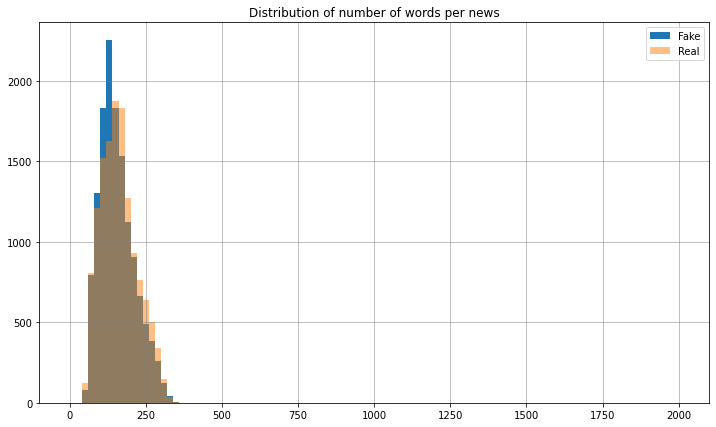

In [141]:
plt.figure(figsize = (12,7))
plt.hist(avg_fake, bins = 100, range = [0, 2000], label='Fake')
plt.hist(avg_real, bins = 100, range = [0, 2000], alpha=0.5, label='Real')
plt.legend(loc='upper right')
plt.title('Distribution of number of words per news')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

In [142]:
#Five-numbers summary for each corpus 
def five_num_summary(dataframe):
    quartiles = np.percentile([len(x.split()) for x in dataframe["text"].tolist()], [0, 25, 50, 75, 100])
    
    return quartiles

true_summ = five_num_summary(dataset_real)

print("Text length - Five-number summary for true news:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, int(true_summ[i//25])))
    
    
print("\n")


fake_summ = five_num_summary(dataset_fake)

print("Text length - Five-number summary for fake news:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, int(fake_summ[i//25])))

Text length - Five-number summary for true news:
0'th %ile: 43
25'th %ile: 117
50'th %ile: 156
75'th %ile: 198
100'th %ile: 357


Text length - Five-number summary for fake news:
0'th %ile: 35
25'th %ile: 113
50'th %ile: 145
75'th %ile: 189
100'th %ile: 368


In [143]:
#Checking examples of the shortest fake news
X_fake_sorted = sorted(X_fake, key = len)
print(X_fake_sorted[:5])

[['rx', 'rude', 'questions', 'relationship', 'secret', 'rex', 'kind', 'bombarded', 'rude', 'questions', 'committed', 'staying', 'position', 'long', 'stay', 'relationship', 'welcome', 'qatari', 'rex', 'style', 'welcome', 'thank', 'thank', 'receiving', 'thank', 'thank', 'committed', 'staying', 'position', 'anywhere', 'long', 'stay', 'long', 'lets', 'relationship'], ['sc', 'hts', 'calling', 'token', 'passed', 'caucus', 'victory', 'lap', 'key', 'hand', 'along', 'mitch', 'mcconnell', 'paul', 'spoke', 'tim', 'scott', 'stood', 'scott', 'key', 'player', 'hard', 'work', 'passing', 'snarky', 'left', 'wait', 'appearance', 'event', 'sickening', 'left', 'practice', 'preaches', 'tolerance', 'hts', 'har', 'cut', 'delivers', 'average', 'single', 'mother', 'cut', 'taxreform', 'foxnews', 'bra'], ['hm', 'pt', 'liberal', 'pic', 'response', 'puts', 'place', 'home', 'co', 'founder', 'kenneth', 'hates', 'irrelevant', 'belong', 'supports', 'shy', 'saying', 'ken', 'co', 'founder', 'home', 'cnbc', 'thinks', 'gr

In [144]:
#Checking examples of the shortest real news
X_real_sorted = sorted(X_real, key = len)
print(X_real_sorted[:5])

[['abe', 'agree', 'boost', 'deterrence', 'japanese', 'shinzo', 'abe', 'boost', 'response', 'program', 'urged', 'phone', 'call', 'strengthen', 'deterrence', 'capability', 'threat', 'deputy', 'cabinet', 'pyongyang', 'fired', 'appeared', 'intercontinental', 'ballistic', 'waters', 'exclusive', 'zone', 'abe', 'needs', 'play', 'increased', 'role', 'countering', 'discuss', 'options', 'toward', 'cabinet', 'separate', 'conference', 'work', 'closely', 'response', 'launch'], ['call', 'tougher', 'chancellor', 'angela', 'condemned', 'test', 'urged', 'quickly', 'agree', 'tougher', 'pyongyang', 'test', 'hydrogen', 'bomb', 'means', 'unacceptable', 'escalation', 'regime', 'steffen', 'spoke', 'telephone', 'chancellor', 'expressed', 'view', 'community', 'must', 'continue', 'exert', 'pressure', 'regime', 'quickly', 'adopt', 'stricter', 'part', 'push', 'tougher', 'adding', 'aim', 'dissuade', 'violations', 'achieve', 'peaceful', 'solution', 'conflict'], ['closer', 'starting', 'tusk', 'encouraged', 'progress

Total #unique words, avg #unique words/news

In [145]:
cnt_real = Counter()
for news in X_real:
  for word in news:
    cnt_real[word] += 1

cnt_fake = Counter()
for news in X_fake:
  for word in news:
    cnt_fake[word] += 1

print("Total unique words in real news: ",len(cnt_real))
print("Total unique words in fake news: ",len(cnt_fake))

Total unique words in real news:  30804
Total unique words in fake news:  30804


Total #char per news, avg #char per news

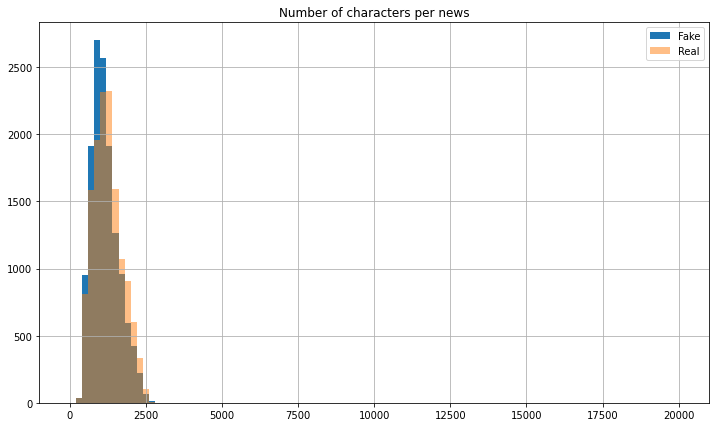

In [146]:
#Comparison of news lengths in characters number between Real and Fake news
plt.figure(figsize = (12,7))
dataset_fake['text'].str.len().hist(bins = 100, range = [0, 20000])
dataset_real['text'].str.len().hist(alpha=0.5, bins = 100, range = [0, 20000])
plt.title('Number of characters per news')
plt.legend(['Fake', 'Real'])
plt.show()

In [147]:
from statistics import mean
print("Real mean news length (in words #): ",mean(dataset_real['text'].str.len()))
print("Fake mean news length (in words #): ",mean(dataset_fake['text'].str.len()))

Real mean news length (in words #):  1253.2604900234742
Fake mean news length (in words #):  1161.2497799295775


## Words frequency

In [0]:
#Word Cloud on real news
text = ''
for news in dataset_real.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del text

In [0]:
#Word Cloud on fake news
text = ''
for news in dataset_fake.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del text

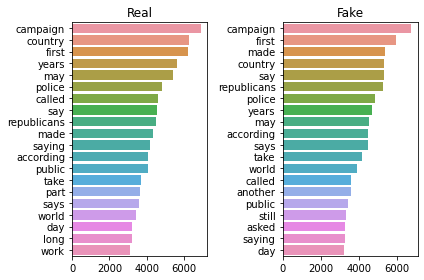

In [148]:
#Let's analyze most frequent words
corpus_real=[word for i in X_real for word in i]
counter_real=Counter(corpus_real)
most_real=counter_real.most_common()

x1, x2= [], []
for word,count in most_real[:40]:
    if (word not in stop_words and len(word) > 1):
        x1.append(word)
        x2.append(count)
 
corpus_fake=[word for j in X_fake for word in j]
counter_fake=Counter(corpus_fake)
most_fake=counter_fake.most_common()

x3, x4= [], []
for word,count in most_fake[:40]:
    if (word not in stop_words and len(word) > 1):
        x3.append(word)
        x4.append(count)

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=x2[:20],y=x1[:20],ax=ax1).set_title('Real')
sns.barplot(x=x4[:20],y=x3[:20],ax=ax2).set_title('Fake')
fig.tight_layout()

Bigrams and trigrams in both classes

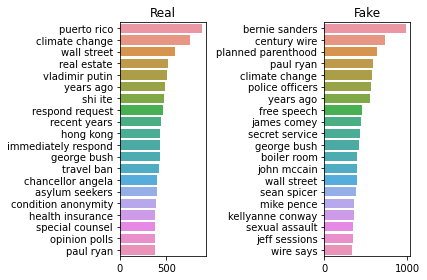

In [149]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

top_n_bigrams_real=get_top_ngram(dataset_real['text'],2)[:20]
x_,y_=map(list,zip(*top_n_bigrams_real))
top_n_bigrams_fake=get_top_ngram(dataset_fake['text'],2)[:20]
w_,z_=map(list,zip(*top_n_bigrams_fake))

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=y_,y=x_,ax=ax1).set_title('Real')
sns.barplot(x=z_,y=w_,ax=ax2).set_title('Fake')
fig.tight_layout()

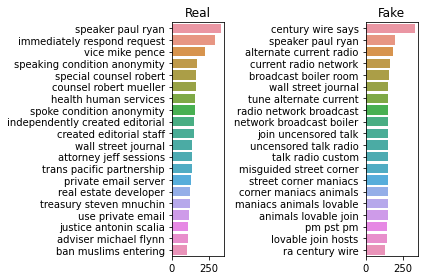

In [150]:
top_trigrams_real=get_top_ngram(dataset_real['text'],3)[:20]
x1_,y1_=map(list,zip(*top_trigrams_real))
top_trigrams_fake=get_top_ngram(dataset_fake['text'],3)[:20]
w1_,z1_=map(list,zip(*top_trigrams_fake))

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=y1_,y=x1_,ax=ax1).set_title('Real')
sns.barplot(x=z1_,y=w1_,ax=ax2).set_title('Fake')
fig.tight_layout()

## TF-IDF, k-means (to be continued)

In [0]:
#Alternative method of analyzing ngrams via TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
class NewTfidfVectorizer(TfidfVectorizer):
    def _word_ngrams(self, tokens, stop_words=None):

        # First get tokens without stop words
        tokens = super(TfidfVectorizer, self)._word_ngrams(tokens, None)
        if stop_words is not None:
            new_tokens=[]
            for token in tokens:
                split_words = token.split(' ')

                # Only check the first and last word for stop words
                if split_words[0] not in stop_words and split_words[-1] not in stop_words:
                    new_tokens.append(token)
            return new_tokens

        return tokens

vectorizer = NewTfidfVectorizer(stop_words='english', ngram_range=(3,3))
vectorizer.fit(bert_dataset["text"])

In [0]:
#K-means
#we can also pursue dimensionality reduction using LSA (I can write this code) if we want to improve further.
X_vec = vectorizer.fit_transform(bert_dataset['text'])
labels = bert_dataset['class']
true_k = np.unique(labels).shape[0]

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,init_size=1000, 
                     batch_size=1000, verbose=False)
print("Clustering sparse data with %s" % km)
km.fit(X_vec)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_vec, km.labels_, sample_size=1000))

print()

## Topic Modeling exploration with pyLDAvis

In [0]:
#Tokenization and lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['text']:
        words=[w for w in nltk.word_tokenize(news) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus_real=preprocess_news(dataset_real)
corpus_fake=preprocess_news(dataset_fake)

In [0]:
#Let’s create the bag of words model using gensim
dic_real=gensim.corpora.Dictionary(corpus_real)
bow_corpus_real = [dic_real.doc2bow(doc_real) for doc_real in corpus_real]

dic_fake=gensim.corpora.Dictionary(corpus_fake)
bow_corpus_fake = [dic_fake.doc2bow(doc_fake) for doc_fake in corpus_fake]

In [0]:
#And finally create the LDA models
lda_model_real = gensim.models.LdaMulticore(bow_corpus_real, 
                                   num_topics = 4, 
                                   id2word = dic_real,                                    
                                   passes = 10,
                                   workers = 2)
lda_model_real.show_topics()

In [0]:
#And finally create the LDA models
lda_model_fake = gensim.models.LdaMulticore(bow_corpus_fake, 
                                   num_topics = 4, 
                                   id2word = dic_fake,                                    
                                   passes = 10,
                                   workers = 2)
lda_model_fake.show_topics()

In [0]:
%%capture
!pip install pyLDAvis

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_real = pyLDAvis.gensim.prepare(lda_model_real, bow_corpus_real, dic_real)
vis_real

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_fake = pyLDAvis.gensim.prepare(lda_model_fake, bow_corpus_fake, dic_fake)
vis_fake

## Readibility index (using Flesch reading ease score formula)

*   90-100 : Very Easy
*   80-89 : Easy
*   70-79 : Fairly Easy
*   60-69 : Standard
*   50-59 : Fairly Difficult
*   30-49 : Difficult
*   0-29 : Very Confusing

The formula for calculating the flesch reading easiness score is given below:

RE = 206.835 – (1.015 x ASL) – (84.6 x ASW)

RE = Readability Ease

ASL = Average Sentence Length (i.e., the number of words divided by the number of sentences)

ASW = Average number of syllables per word (i.e., the number of syllables divided by the number of words)

In [0]:
%%capture
!pip install textstat

In [0]:
#The analysis must be performed on the original dataset, before data preprocessing
import textstat as ts

real_news_readability = []
fake_news_readability = []

for sentence in dataset.loc[dataset['class'] == 1]["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    real_news_readability.append(temp)
    
for sentence in dataset.loc[dataset['class'] == 0]["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    fake_news_readability.append(temp)

In [0]:
real_readability_df = pd.Series(real_news_readability)
fake_readability_df = pd.Series(fake_news_readability)

plt.figure(figsize = (12,7))
plt.hist(fake_readability_df, bins = 10, range = [0, 100], label = "fake-news readability")
plt.hist(real_readability_df, bins = 10, range = [0, 100], alpha = 0.5, label = "real-news readability")
plt.xlabel("Flesch readability easiness for a news article", fontsize = 12)
plt.ylabel("Number of articles with x word length", fontsize = 12)
plt.title("Class wise Flesch readability ease score distribution", fontsize = 15)
plt.legend()
plt.show()

## Sentiment analysis

With Vader library

```
Vader uses a bag of words approach (a lookup table of positive and negative words) with some simple heuristics (e.g. increasing the intensity of the sentiment if some words like “really”, “so” or “a bit” are present).`
The advantage of this approach is that sentences containing negated positive words (e.g. “not happy”, “not good”) will still receive a negative sentence sentiment (thanks to the heuristics to flip the sentiment of the word following a negation).
Vader is sensitive to punctuation, capitalization, degree modifiers, Preceding Tri-gram
```
The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.
*   Positive sentiment: compound score >= 0.05
*   Neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
*   Negative sentiment: compound score <= -0.05

The pos, neu, and neg scores are ratios for proportions of text that fall in each category. These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

In [151]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [152]:
vader.polarity_scores('this is great')

{'compound': 0.6249, 'neg': 0.0, 'neu': 0.328, 'pos': 0.672}

In [0]:
def get_vader_sent(val):
  if val >= 0.05:
    return "pos"
  elif val <= -0.05:
    return "neg"
  else:
    return "neu"

In [154]:
# Checking with non preprocessed data (hence including punctuation, upper case, etc.)
vader_real = []
sentiments_real = dataset.loc[dataset['class'] == 1]["text"].tolist()

for i in range(len(sentiments_real)):
  vader_real.append(vader.polarity_scores(str(sentiments_real[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_real)):
  comp.append(vader_real[j]['compound'])
  pos.append(vader_real[j]['pos'])
  neg.append(vader_real[j]['neg'])
  neu.append(vader_real[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  0.05031555772539132 Positive:  0.0821281908215931 Neutral:  0.8382001208908725 Negative : 0.07966852652624717


In [155]:
sent_real = [get_vader_sent(x) for x in comp]
sent_real[:10]

['neg', 'neg', 'pos', 'pos', 'neg', 'neg', 'pos', 'neg', 'pos', 'neg']

In [156]:
vader_fake = []
sentiments_fake = dataset.loc[dataset['class'] == 0]["text"].tolist()

for i in range(len(sentiments_fake)):
  vader_fake.append(vader.polarity_scores(sentiments_fake[i]))

comp_fake = []
pos_fake = []
neg_fake = []
neu_fake = []
for j in range(len(vader_fake)):
  comp_fake.append(vader_fake[j]['compound'])
  pos_fake.append(vader_fake[j]['pos'])
  neg_fake.append(vader_fake[j]['neg'])
  neu_fake.append(vader_fake[j]['neu'])

print("Compound: ",sum(comp_fake)/len(comp_fake), "Positive: ",sum(pos_fake)/len(pos_fake),"Neutral: ", sum(neu_fake)/len(neu_fake),"Negative :", sum(neg_fake)/len(neg_fake))

Compound:  -0.09969408508412633 Positive:  0.09040061895214029 Neutral:  0.8118038531950186 Negative : 0.09740122918664526


In [157]:
sent_fake = [get_vader_sent(x) for x in comp_fake]
sent_fake[:10]

['pos', 'pos', 'pos', 'neg', 'neu', 'neg', 'pos', 'neg', 'neg', 'neg']

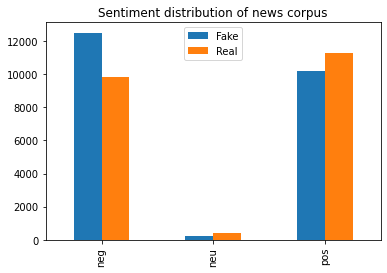

In [158]:
real_unique, real_count = np.unique(sent_real, return_counts=True)
fake_unique, fake_count = np.unique(sent_fake, return_counts=True)
vader_sent = pd.DataFrame(data={'sentiments':real_unique, 'Fake':fake_count, "Real":real_count})

ax = vader_sent.plot.bar()
ax.set(xticklabels = vader_sent['sentiments'])
plt.legend(loc='upper center')
plt.title('Sentiment distribution of news corpus')
plt.show()

In [159]:
# Checking the same with preprocessed data (without punctuation, upper case, etc.)
vader_real = []
sentiments_real_bert = bert_dataset.loc[bert_dataset['class'] == 1]["text"].tolist()

for i in range(len(sentiments_real_bert)):
  vader_real.append(vader.polarity_scores(str(sentiments_real_bert[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_real)):
  comp.append(vader_real[j]['compound'])
  pos.append(vader_real[j]['pos'])
  neg.append(vader_real[j]['neg'])
  neu.append(vader_real[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  -0.2094195275821599 Positive:  0.13043067781690165 Neutral:  0.6994759389671389 Negative : 0.1700951437793424


In [160]:
vader_fake = []
sentiments_fake_bert = bert_dataset.loc[bert_dataset['class'] == 0]["text"].tolist()

for i in range(len(sentiments_fake_bert)):
  vader_fake.append(vader.polarity_scores(sentiments_fake_bert[i]))

comp_fake = []
pos_fake = []
neg_fake = []
neu_fake = []
for j in range(len(vader_fake)):
  comp_fake.append(vader_fake[j]['compound'])
  pos_fake.append(vader_fake[j]['pos'])
  neg_fake.append(vader_fake[j]['neg'])
  neu_fake.append(vader_fake[j]['neu'])

print("Compound: ",sum(comp_fake)/len(comp_fake), "Positive: ",sum(pos_fake)/len(pos_fake),"Neutral: ", sum(neu_fake)/len(neu_fake),"Negative :", sum(neg_fake)/len(neg_fake))

Compound:  -0.28598847564553986 Positive:  0.1472433245305161 Neutral:  0.6577247652582149 Negative : 0.19502824237089206


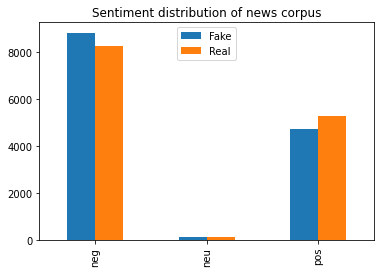

In [161]:
sent_bert_real = [get_vader_sent(x) for x in comp]
sent_bert_fake = [get_vader_sent(x) for x in comp_fake]

bert_real_unique, bert_real_count = np.unique(sent_bert_real, return_counts=True)
bert_fake_unique, bert_fake_count = np.unique(sent_bert_fake, return_counts=True)
vader_bert_sent = pd.DataFrame(data={'sentiments':bert_real_unique, 'Fake':bert_fake_count, "Real":bert_real_count})

ax = vader_bert_sent.plot.bar()
ax.set(xticklabels = vader_bert_sent['sentiments'])
plt.legend(loc='upper center')
plt.title('Sentiment distribution of news corpus')
plt.show()

In [162]:
vader.polarity_scores(sentiments_real[10])

{'compound': 0.9981, 'neg': 0.076, 'neu': 0.803, 'pos': 0.12}

With TextBlob


```
TextBlob uses a bag of words classifier, but the advantage is that it includes Subjectivity Analysis too (how factual/opinionated a piece of text is).
However, it doesn’t contain the heuristics that NLTK has, and so it won’t intensify or negate a sentence’s sentiment.
```


*   polarity: negative vs. positive    (-1.0 => +1.0)
*   subjectivity: objective vs. subjective (+0.0 => +1.0)



In [163]:
from textblob import TextBlob
TextBlob(sentiments_real[10]).sentiment

Sentiment(polarity=0.12359053309757537, subjectivity=0.4665880129260413)

In [164]:
# Checking with non preprocessed data (hence including punctuation, upper case, etc.)
pol_real = []
subj_real = []

for i in range(len(sentiments_real)):
  pol_real.append(TextBlob(sentiments_real[i]).sentiment.polarity)
  subj_real.append(TextBlob(sentiments_real[i]).sentiment.subjectivity)

print("Polarity: ",mean(pol_real), "Subjectivity: ",mean(subj_real))

Polarity:  0.0533483268653243 Subjectivity:  0.36118319780445135


In [165]:
pol_fake = []
subj_fake = []

for i in range(len(sentiments_fake)):
  pol_fake.append(TextBlob(sentiments_fake[i]).sentiment.polarity)
  subj_fake.append(TextBlob(sentiments_fake[i]).sentiment.subjectivity)

print("Polarity: ",mean(pol_fake), "Subjectivity: ",mean(subj_fake))

Polarity:  0.05956552294756349 Subjectivity:  0.45311592652418053


In [166]:
# Checking the same with preprocessed data (without punctuation, upper case, etc.)
pol_real = []
subj_real = []

for i in range(len(sentiments_real_bert)):
  pol_real.append(TextBlob(sentiments_real_bert[i]).sentiment.polarity)
  subj_real.append(TextBlob(sentiments_real_bert[i]).sentiment.subjectivity)

print("Polarity: ",mean(pol_real), "Subjectivity: ",mean(subj_real))


Polarity:  0.04000926564150968 Subjectivity:  0.4279161375172477


In [167]:
pol_fake = []
subj_fake = []

for i in range(len(sentiments_fake_bert)):
  pol_fake.append(TextBlob(sentiments_fake_bert[i]).sentiment.polarity)
  subj_fake.append(TextBlob(sentiments_fake_bert[i]).sentiment.subjectivity)

print("Polarity: ",mean(pol_fake), "Subjectivity: ",mean(subj_fake))

Polarity:  0.031684564561331625 Subjectivity:  0.4940257366911251


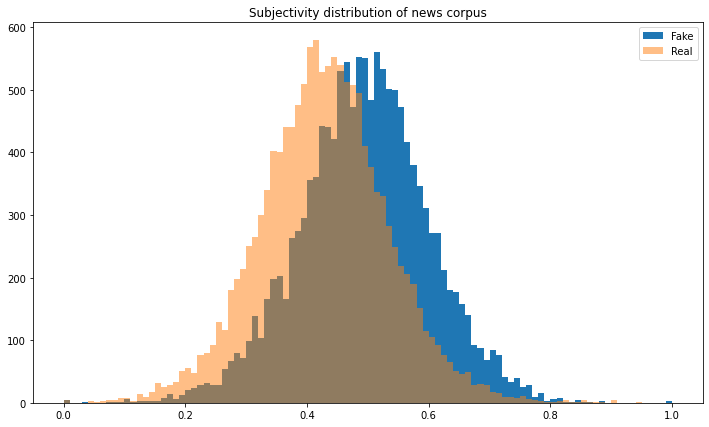

In [168]:
plt.figure(figsize = (12,7))
plt.hist(subj_fake, bins = 100, range = [0, 1], label='Fake')
plt.hist(subj_real, bins = 100, range = [0, 1], alpha=0.5, label='Real')
plt.legend(loc='upper right')
plt.title('Subjectivity distribution of news corpus')
plt.show()

With Fair


```
Flair’s sentiment classifier is based on a character-level LSTM neural network which takes sequences of letters and words into account when predicting.
The network has learnt to take negations into account, as well as intensifiers.
It can also predict OOV words that it has never seen before (contrary to the 2 other libraries)
```



In [0]:
#%%capture
#!pip3 install flair
#import flair

In [0]:
#flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
#s = flair.data.Sentence(sentiments_real[10])
#flair_sentiment.predict(s)
#total_sentiment = s.labels
#total_sentiment

## Naive Bayes Text feature importance

In [0]:
NUM_FEATURES = 20

# getting the indexes of the top features by class
fake_prob_sorted = naive_bayes_model.feature_log_prob_[0, :].argsort()[::-1]
real_prob_sorted = naive_bayes_model.feature_log_prob_[1, :].argsort()[::-1]

# getting the top feature names
fake_top_features = np.take(vectorizer.get_feature_names(), fake_prob_sorted[:NUM_FEATURES])
real_top_features = np.take(vectorizer.get_feature_names(), real_prob_sorted[:NUM_FEATURES])

# creating dictionaries for each class with the feature name and log probability
real_dict = {k:v for k, v in zip(
                                real_top_features, 
                                np.take(naive_bayes_model.feature_log_prob_[1, :], real_prob_sorted[:NUM_FEATURES])
                                )
            }

fake_dict = {k:v for k, v in zip(
                                fake_top_features, 
                                np.take(naive_bayes_model.feature_log_prob_[0, :], fake_prob_sorted[:NUM_FEATURES])
                                )
            }

In [170]:
# creating a dataframe using the dictionaries of top terms per class
top_terms = pd.DataFrame.from_dict(real_dict, orient='index')
top_terms.reset_index(inplace=True)
top_terms.rename(columns={'index': 'term', 0: 'log_prob'}, inplace=True)
top_terms['label'] = 'Real'

# add the top terms for the fake class
for term, log_prob in fake_dict.items():
    top_terms = top_terms.append({'term': term, 'log_prob': log_prob, 'label': 'Fake'}, ignore_index=True)

# convert log probability to odds ratio
top_terms['odds'] = top_terms.log_prob.apply(np.exp)

# sort alphabetically
top_terms = top_terms.sort_values('term', ascending=True)

top_terms.head(10)

,term,log_prob,label,odds
31,according,-7.152033,Fake,0.000783
12,according,-7.251616,Real,0.000709
34,another,-7.245387,Fake,0.000713
39,asked,-7.325097,Fake,0.000659
7,called,-7.133854,Real,0.000798
20,campaign,-6.680461,Fake,0.001255
0,campaign,-6.734288,Real,0.001189
2,country,-6.874884,Real,0.001033
26,country,-7.008495,Fake,0.000904
23,first,-6.954883,Fake,0.000954


In [0]:
# creating dictionary to be used for plotting
top_terms["idx"]=range(0,len(top_terms))
y_map = top_terms["term"][:NUM_FEATURES*2]
#y_map = {term: y for y, term in zip(range(0, top_terms.shape[0]), top_terms.term)}

plot_map = {} 
for index, row in top_terms.iterrows():
    term = row['term']
    if term in plot_map:
      term = term+" "
    
    plot_map[term] = {
        'x': row['odds'],
        'y': row['idx'],
#        'y': y_map[term],
        'c': 'red' if row['label'] == 'Fake' else 'blue'
    } 

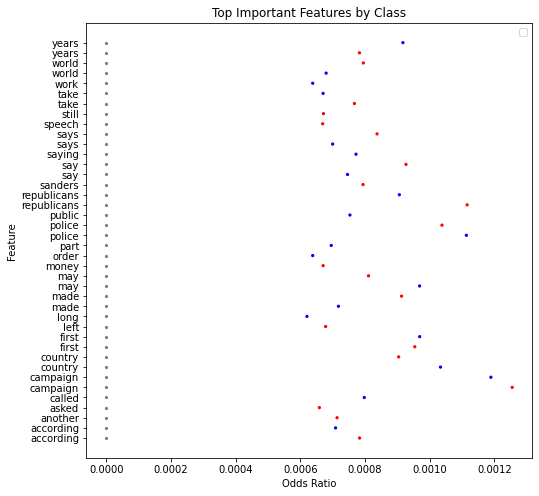

In [172]:
# plotting
fig = plt.figure(figsize=(8, 8))
_ = plt.scatter(
            [value['x'] for key, value in plot_map.items()], 
            [value['y'] for key, value in plot_map.items()],
            s=5,
            color=[value['c'] for key, value in plot_map.items()],
)

_ = plt.scatter(
    [0]* top_terms.shape[0],
    [r for r in range(0, top_terms.shape[0])],
    s=5,
    color='grey'
)

plt.legend()
plt.yticks(ticks=[r for r in range(0, top_terms.shape[0])], labels=y_map)
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.title('Top Important Features by Class')
plt.show()

## K-Means on W2V vectors

In [0]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from itertools import cycle

def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(word_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers]
    closest_words_idxs = [x[1] for x in closest_points]

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {}
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words)
    df.index = df.index+1

    return df

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


def display_cloud(cluster_num, cmap, words_df):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap)
    wordcloud = wc.generate(' '.join([word for word in words_df['Cluster #' + str(cluster_num).zfill(2)]]))
    plt.figure(cluster_num)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')


cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

NUM_CLUSTERS = 10
EMBEDDING_DIM = 100

In [0]:
w2v_model_real = gensim.models.Word2Vec(sentences=X_real, size=EMBEDDING_DIM, window=5, min_count=5)
w2v_model_fake = gensim.models.Word2Vec(sentences=X_fake, size=EMBEDDING_DIM, window=5, min_count=5)

Starting with Fake news

In [0]:
centers_fake, clusters_fake = clustering_on_wordvecs(w2v_model_fake.wv.syn0, NUM_CLUSTERS)
centroid_map_fake = dict(zip(w2v_model_fake.wv.index2word, clusters_fake))

In [176]:
#Getting words in each cluster that are closest to the cluster center
top_words_fake = get_top_words(w2v_model_fake.wv.index2word, 20, centers_fake, w2v_model_fake.wv.syn0)
top_words_fake

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10
1,choir,invasion,katy,diving,confidential,profits,mandates,fragile,stabbing,candidacy
2,seeming,persecution,hayes,researched,contacts,subsidies,systematically,sane,fatally,swing
3,weighs,influx,laura,bananas,briefed,goods,stem,utterly,gunfire,landslide
4,va,discriminate,tur,renovations,reviewed,savings,component,narcissistic,spotted,backing
5,costumes,palestinians,legendary,installations,inspector,burden,branches,embrace,alton,favorable
6,depicted,gays,commented,songbird,memos,expensive,strictly,pretending,spray,rival
7,wen,ethnic,ana,routes,associates,recipients,regulate,narcissist,metro,primaries
8,wet,banning,ash,omit,cheryl,insurers,assisted,demagogue,nearby,superdelegates
9,blessing,origin,nick,chanel,committees,reduction,establishing,temperament,parking,endorse
10,da,jihad,amy,labyrinth,subpoena,increases,maintaining,surely,su,bid


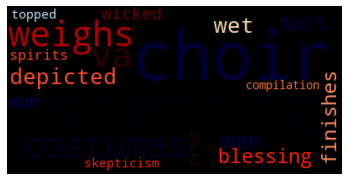

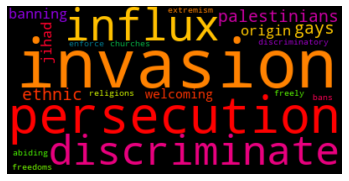

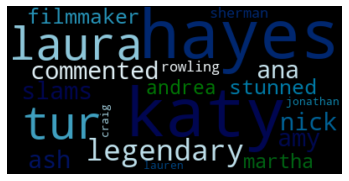

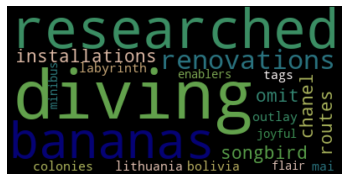

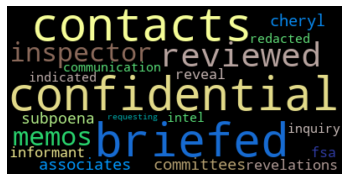

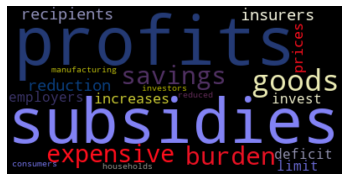

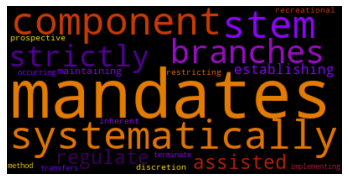

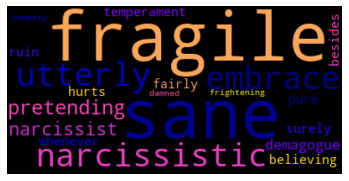

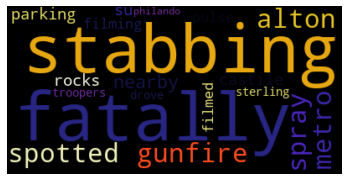

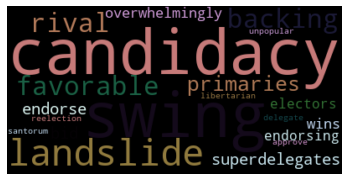

In [177]:
#Displaying clusters via WordClouds
for fi in range(NUM_CLUSTERS):
    col = next(cmaps)
    display_cloud(fi+1, col, top_words_fake)


And with Real news

In [0]:
centers_real, clusters_real = clustering_on_wordvecs(w2v_model_real.wv.syn0, NUM_CLUSTERS)
centroid_map_real = dict(zip(w2v_model_real.wv.index2word, clusters_real))

In [179]:
#Getting words in each cluster that are closest to the cluster center
top_words_real = get_top_words(w2v_model_real.wv.index2word, 20, centers_real, w2v_model_real.wv.syn0)
top_words_real

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10
1,engraved,contemporary,runoff,murphy,outskirts,barring,examining,mansour,realistic,generate
2,opportunism,despair,socialists,jay,checkpoint,directive,revealed,jihadists,achieving,earnings
3,coins,phrases,scored,dan,blew,violates,leaking,peacekeepers,meaningful,incentives
4,jeep,railing,tight,blumenthal,burnt,prohibits,unrelated,occupation,emphasize,premium
5,smoked,fool,polled,leahy,rubble,mcauliffe,misleading,sectarian,helpful,reductions
6,passers,buddy,gubernatorial,sherrod,entrance,statute,cooperating,battling,complicate,lowering
7,ungrateful,dresses,di,brian,crashed,lawful,inquiries,loyal,stressing,hikes
8,memorials,enjoying,trailing,patrick,worshippers,amend,leak,paramilitary,broadly,retailers
9,encompassed,pure,outsider,jon,wooden,licenses,snowden,annexed,practical,costly
10,dentist,tale,pd,harris,windows,injunction,farenthold,commanders,cautious,taxation


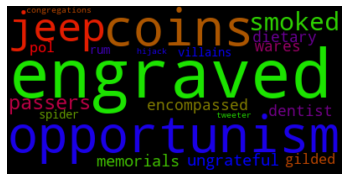

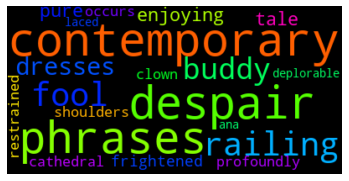

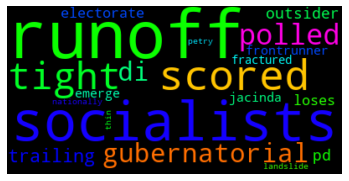

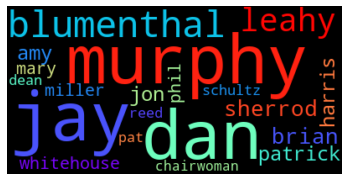

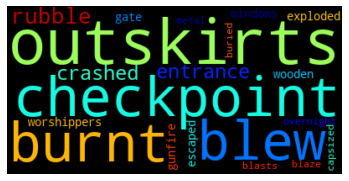

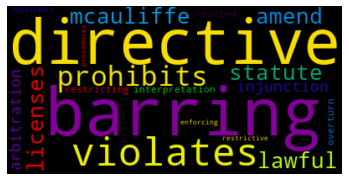

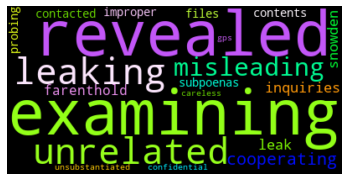

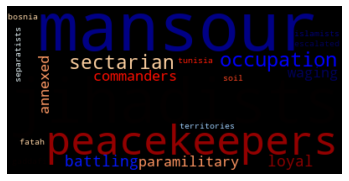

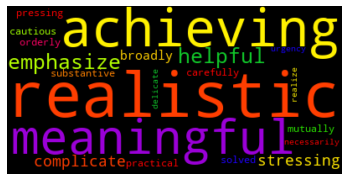

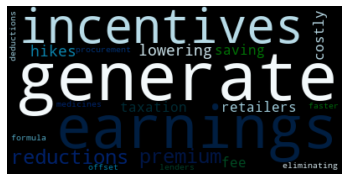

In [180]:
#Displaying clusters via WordClouds
for ri in range(NUM_CLUSTERS):
    col = next(cmaps);
    display_cloud(ri+1, col, top_words_real)